# The representation of women in the movie industry around the world

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import pycountry
import pycountry_convert as pc
import swifter

from functools import lru_cache
from scipy import stats
from itertools import islice
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import networkx as nx

from helpers_corenlp import *
from functions import *

from IPython.display import HTML
import plotly.graph_objs as go
from itertools import islice

from statannotations.Annotator import Annotator

from branca.colormap import linear

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

#import folium
import json

**Table of content**

1. [Data pre-processing](#Data-pre-processing)
    - [Part 1: CMU Movie Summary](#part1)
    - [Part 2: Movies Dataset: find the main character](#part1.2)
    - [Part 3: CoreNLP parsed movie summaries dataset](#part1.3)
    - [Part 4: IMDB Datasets](#part1.4)
    - [Part 5: Oscars Dataset](#part1.5)
2. [Data Analysis](#Data-analysis)
    - [Part 1: Quantitative analysis of gender inequalities in movies](#part2.1)
    - [Part 2: Qualititative analysis of gender representation in movies](#part2.2)
    - [Part 3: Analysis of the reception of movies by the public](#part2.3)
    - [Part 4:  Analysis by geographical production region](#part2.4)

## STEP 1: DATA PRE-PROCESSING <a class="anchor" id="Data-pre-processing"></a>

---

In [374]:
current_directory = os.getcwd()

DATA_PATH = os.path.join(current_directory, 'MovieSummaries')
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
CHARACTER_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
CHARACTER_TYPE_PATH = os.path.join(DATA_PATH, 'tvtropes.clusters.txt')
PLOT_SUMMARIES_PATH = os.path.join(DATA_PATH, 'plot_summaries.txt')
RATINGS_PATH = os.path.join(current_directory, 'Ratings_PreProcessed.tsv')

CORE_NLP_PATH = os.path.join(current_directory, 'corenlp')
CORE_NLP_GZ = CORE_NLP_PATH + "/corenlp_plot_summaries"
CORE_NLP_XML = CORE_NLP_PATH + "/corenlp_plot_summaries_xml"

IMDB_PATH = os.path.join(current_directory, 'IMDB')
IMDB_BASICS_PATH = IMDB_PATH + "/title.basics.tsv"
IMDB_RATINGS_PATH = IMDB_PATH + "/title.ratings.tsv"

BECHDEL_PATH = os.path.join(current_directory, 'bechdel_movies_2023_FEB.csv')

AWARDS_PATH = os.path.join(current_directory, 'the_oscar_award.csv')

CREDITS_PATH = os.path.join(current_directory, 'credits.csv')
MOVIES_CREDITS_PATH = os.path.join(current_directory, 'movies_metadata.csv')

## PART 1: CMU Movie Summary <a id="part1"></a>

### Movies.metadata & characters.metadata

In [375]:
# Load the datasets
headers_movies = ['WikiMovieID', 
                  'FreebaseMovieID', 
                  'MovieName', 
                  'ReleaseDate', 
                  'BORevenue', 
                  'Runtime',
                  'Languages', 
                  'Countries', 
                  'MovieGenre']

headers_characters = ['WikiMovieID', 
                      'FreebaseMovieID', 
                      'ReleaseDate', 
                      'CharacterName', 
                      'DoB', 
                      'Gender', 
                      'Height', 
                      'Ethnicity', 
                      'ActorName', 
                      'Age', 
                      'FreebaseActorMapID', 
                      'FreebaseCharacterID', 
                      'FreebaseActorID']

movies = pd.read_csv(MOVIE_PATH, sep='\t', names=headers_movies)
characters = pd.read_csv(CHARACTER_PATH, sep='\t', names=headers_characters)

In [376]:
nb_movie = movies['WikiMovieID'].nunique()
print(f'The movie dataset contains {nb_movie} movies')
movies.sample(3)

The movie dataset contains 81741 movies


,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre
14740,8517247,/m/02768l9,Jackpot,2001-07-27,NaN,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01z4y"": ""Comedy""}"
2897,24862296,/m/09gk_n1,My Financial Career,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hqxf"": ""Famil..."
60492,10044434,/m/02p_yvh,The New and Improved DX,2007-02-20,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02kdv5l"": ""Action""}"


In [377]:
nb_char = len(characters.index)
print(f'The characters dataset contains {nb_char} characters')
print('Percentage of missing entries in the character.metadata dataset:')
print(100*characters[['FreebaseMovieID', 'ReleaseDate', 'CharacterName','DoB', 'Gender', 'Height', 'Ethnicity',
                        'ActorName', 'Age', 'FreebaseCharacterID','FreebaseActorID']].isna().sum() / len(characters))
characters.sample(3)

The characters dataset contains 450669 characters
Percentage of missing entries in the character.metadata dataset:
FreebaseMovieID         0.000000
ReleaseDate             2.217814
CharacterName          57.220488
DoB                    23.552763
Gender                 10.120288
Height                 65.645740
Ethnicity              76.466542
ActorName               0.272484
Age                    35.084064
FreebaseCharacterID    57.218269
FreebaseActorID         0.180842
dtype: float64


,WikiMovieID,FreebaseMovieID,ReleaseDate,CharacterName,DoB,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
183945,24668194,/m/0809jj_,1984-08-03,NaN,1945-12-17,M,1.829,/m/0x67,Ernie Hudson,38.0,/m/09ly9nz,NaN,/m/03fnyk
444220,5187488,/m/0d6x5t,1943-06-03,Cpl. Barney Todd,1902-08-11,M,1.790,NaN,Lloyd Nolan,40.0,/m/02vbbqs,/m/0hq8dvv,/m/06fgbb
132045,31165667,/m/09pgjvj,1946-12,Flo,1928-01-28,F,NaN,NaN,Lila Leeds,NaN,/m/0hpmzkw,/m/0hpmzj8,/m/06049d


##### Gender

Our project focuses on differences between gender representation in movies; thus we keep only movies where we have gender information.

In [378]:
print('Percentage of missing gender entries in the character dataset:') 
print(100*characters[['Gender']].isna().sum() / len(characters))

# Keep only the rows for which we have the gender of the actor/actress
characters = characters.loc[characters['Gender'].isin(['F', 'M'])].copy(deep=True)
print(f'The character dataset contains {len(characters.index)} characters after filtering on the characters gender')

#Remove the movies where we don't have the gender of the actor/actress
movies = movies[movies['WikiMovieID'].isin(characters['WikiMovieID'])]

Percentage of missing gender entries in the character dataset:
Gender    10.120288
dtype: float64


The character dataset contains 405060 characters after filtering on the characters gender


##### Release date

In [379]:
# The movie 'Hunting Season' has an incorrect date: 1010 instead of 2010
characters['ReleaseDate'] = characters['ReleaseDate'].replace('1010-12-02', '2010-12-02')
movies['ReleaseDate'] = movies['ReleaseDate'].replace('1010-12-02', '2010-12-02')

# Convert the date in the column 'ReleaseDate' into datetime
characters_ReleaseDate_datatime = characters['ReleaseDate'].apply(convert_date)
movies_ReleaseDate_datatime = movies['ReleaseDate'].apply(convert_date)

# Add a column with the year of release only
characters['ReleaseYear'] = characters_ReleaseDate_datatime.dt.year.fillna(0).astype(int)
characters['ReleaseYear'] = characters['ReleaseYear'].astype('int64')
characters['ReleaseYear'].replace(0, np.nan, inplace=True)

movies['ReleaseYear'] = movies_ReleaseDate_datatime.dt.year.fillna(0).astype(int)
movies['ReleaseYear'] = movies['ReleaseYear'].astype('int64')
movies['ReleaseYear'].replace(0, np.nan, inplace=True)

In [380]:
characters.sample(2)

,WikiMovieID,FreebaseMovieID,ReleaseDate,CharacterName,DoB,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear
286494,26622049,/m/0bc45yw,1994,NaN,NaN,M,NaN,NaN,Mike Genovese,NaN,/m/0gc5600,NaN,/m/0gbxfwc,1994.0
20443,6924662,/m/0gx8p4,2006-09-28,Rapist,NaN,M,NaN,NaN,Anthony Neal,NaN,/m/0j96b12,/m/0j96b15,/m/0j96b1d,2006.0


In [381]:
movies.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear
47212,25036403,/m/09gllw6,Martin Scorsese Presents: Val Lewton - The Man...,2007,NaN,77.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/0jtdp"": ""Documentary""}",2007.0
29321,20765579,/m/057sjcr,Crime in Connecticut: The Story of Alex Kelly,1999-03-16,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama""}",1999.0


##### Age

In [382]:
# Replace null or negative age values by NaN
characters['Age'] = characters['Age'].apply(lambda x: np.nan if x <= 0 else x)

##### Deal with dictionnaries

In [383]:
# Convert the str-like dictionaries to dictionaries
movies['Countries'] = movies['Countries'].apply(ast.literal_eval)
movies['MovieGenre'] = movies['MovieGenre'].apply(ast.literal_eval)
movies['Languages'] = movies['Languages'].apply(ast.literal_eval)

In [384]:
movies.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear
24948,2221107,/m/06w_w0,The Fallen Idol,1948,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/02n4kr': 'Myster...",1948.0
69591,26371114,/m/0bbvwjg,Ricky Rapper and the Bicycle Thief,NaN,3151286.0,100.0,{},{},"{'/m/0hqxf': 'Family Film', '/m/04t36': 'Music...",NaN


##### Movie Genre

We first find the 16 more common movie genres in our dataset.

In [385]:
all_unique_genres = set()

# Get all the movie genres
movies['MovieGenre'].apply(lambda x: all_unique_genres.update(x.values()) if isinstance(x, dict) else None)

# Initialize dictionary with keys and values set to 0
genres_count = {genre: 0 for genre in all_unique_genres}

# Count the occurence of each genre
for row in movies['MovieGenre']:
    for key, value in row.items():
        genres_count[value]+=1
        
# Sort the dictionary by values in descending order
genres_count = dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True))

In [386]:
# Keep the first 16 major genres
major_16_genres = dict(islice(genres_count.items(), 16))

fig = go.Figure(data=[
    go.Bar(
            x = np.arange(len(major_16_genres)),
            y = list(major_16_genres.values()),
            marker= dict(color = 'rgba(0, 158, 115, 0.5)')
        )]
)

fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    title= "16 Major Genres of Movies",
    xaxis_title="Genres",
    yaxis_title= "Number of movie for each genre"
)

# Add custom x-axis tick labels and rotate them vertically
fig.update_xaxes(
    tickvals=np.arange(len(major_16_genres)),
    ticktext=list(major_16_genres.keys()),
    tickangle=-90
)

fig.write_html("plots/movie_genres.html")
fig.show()

Then for the analysis we consider that each movie must have at least one genre:
- If no genre is given, then we drop the movie.  
- If a movie has several genres: 
    - if one appears in the 16 major genres, we keep it as the movie's genre.
    - if several appear in the 16 major genres, we keep the first one as the movie's genre.
    - if none appears in the 16 major genres, we keep the first genre of the list as the movie's genre.


In [387]:
# List of rows to drop 
rows_to_drop = []

for index, row in movies.iterrows():
    movie_genre = row['MovieGenre']
        
    # If there is no genre, drop the corresponding row
    if not bool(movie_genre):
        rows_to_drop.append(index)
            
    # If there are multiple genres        
    else:
        count = 0  # To keep the first value only
        for key, value in movie_genre.items():
            if value in major_16_genres:
                if count == 0:
                    value_to_keep = value
                    key_to_keep = key
                    count = 1
                    break
        
        if count == 0: # if none of the genre is in the first 16 genre, keep the first one

            movies.at[index, 'MovieGenre'] = {list(movie_genre.keys())[0]: list(movie_genre.values())[0]}

        #if count == 0:  # If none of the genres is in the major_16_genres, drop the row
        #    rows_to_drop.append(index)

        if count == 1:
            movies.at[index, 'MovieGenre'] = {key_to_keep: value_to_keep}

# Create a new DataFrame with only the rows to keep
movies = movies.drop(rows_to_drop)
movie_counts = movies['WikiMovieID'].nunique()
print(f'We are left with {movie_counts} movies')

We are left with 62455 movies


##### Merge the characters & movies datasets

In [388]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
# We perform an inner join to populate characters with movies
cmu = movies.merge(characters, how='inner', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate', 'ReleaseYear'])
cmu = cmu.drop(['DoB', 'Height', 'Runtime'], axis=1).copy(deep=True)

print(f'The cmu dataset contains {len(cmu.index)} entries')
cmu.sample(2)

The cmu dataset contains 401059 entries


,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
337126,28296161,/m/0cnz1j9,Barbed Wire,1952-07-25,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/03btsm8': 'Action/Adventure'},1952.0,NaN,M,NaN,Leonard Penn,44.0,/m/0gc44yj,NaN,/m/0cc55kl
178918,4954774,/m/0cwy47,Cleopatra,1963-06-12,57777778.0,{'/m/02h40lc': 'English Language'},"{'/m/09c7w0': 'United States of America', '/m/...",{'/m/07s9rl0': 'Drama'},1963.0,Ramos,M,/m/041rx,Martin Benson,44.0,/m/0cs5c6n,/m/0h5nlky,/m/0bbv510


In [389]:
print('Percentage of missing entries in the cmu dataset:') 
print(100*cmu[['WikiMovieID', 'FreebaseMovieID', 'MovieName', 'ReleaseDate', 'BORevenue', 'ReleaseYear', 
               'CharacterName','Gender', 'Ethnicity', 'ActorName', 'Age', 'FreebaseCharacterID',
               'FreebaseActorID', 'FreebaseActorMapID']].isna().sum() / len(cmu))

print(f"\nLanguages {percent_missing_strdict(cmu['Languages']):.2f}%")
print(f"Countries {percent_missing_strdict(cmu['Countries']):.2f}%")
print(f"MovieGenre {percent_missing_strdict(cmu['MovieGenre']):.2f}%")                                                                                  

Percentage of missing entries in the cmu dataset:
WikiMovieID             0.000000
FreebaseMovieID         0.000000
MovieName               0.000000
ReleaseDate             2.336065
BORevenue              76.506948
ReleaseYear             2.336065
CharacterName          53.946177
Gender                  0.000000
Ethnicity              73.910821
ActorName               0.002992
Age                    28.245470
FreebaseCharacterID    53.944183
FreebaseActorID         0.000000
FreebaseActorMapID      0.000000
dtype: float64

Languages 7.27%
Countries 3.46%
MovieGenre 0.00%


To be consistent in our analysis, we want a minimum of 200 movies and 100 characters per year.

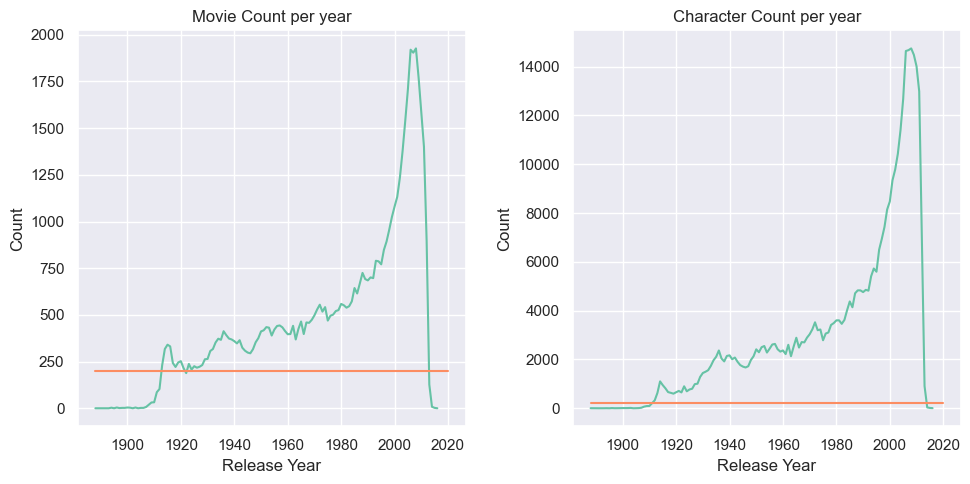

In [390]:
# Plot the number of movies and of characters per year
movie_count_per_year = cmu.groupby(['ReleaseYear']).agg({'WikiMovieID' : 'nunique'})
character_count_per_year = cmu.groupby(['ReleaseYear']).agg({'Gender': 'count'})

sns.set_style("darkgrid")

fig, (ax1, ax2) = plt.subplots(1,2,figsize= (10,5))
ax1.plot(movie_count_per_year)
ax1.plot([1888, 2020], [200, 200])
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Count')
ax1.set_title('Movie Count per year')

ax2.plot(character_count_per_year)
ax2.plot([1888, 2020], [200, 200])
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Count')
ax2.set_title('Character Count per year')

plt.tight_layout()
plt.show()

In [391]:
# Keep only movies between 1925 and 2012 to have at least 200 movies per year and at least 100 characters per year.
cmu = cmu.loc[(cmu['ReleaseYear'] >= 1925) & (cmu['ReleaseYear'] <= 2012)].copy(deep=True)
print(f'The cmu dataset contains {len(cmu.index)} entries after filtering to have at least 200 movies and 100 characters per year.')

The cmu dataset contains 380822 entries after filtering to have at least 200 movies and 100 characters per year.


### Add geographical data to our dataset

We will perform a geographical analysis; for this purpose, we will create specialized datasets.  

In [392]:
#Initial number of rows in the movies dataset
nb_row_countries = len(movies)

# Create a new dataset from movies where we remove the rows in the 'Countries' column that lack information about countries.
movies_geo = movies[movies['Countries'].apply(lambda x: len(x)!=0)].copy(deep=True)

num_rows_dropped = nb_row_countries-len(movies_geo)
percentage_rows_dropped = (num_rows_dropped / nb_row_countries) * 100
print(f'We dropped {num_rows_dropped} rows, corresponding to {percentage_rows_dropped:.2f}% of our original movies dataset.')

We dropped 4668 rows, corresponding to 7.47% of our original movies dataset.


In [393]:
# We convert the column type from dictionaries to a list of strings.
movies_geo['Countries'] = movies_geo['Countries'].apply(lambda x: [val for val in x.values()])

To facilitate the analysis, we will utilize the ISO databases available in the pycountry library for standardized country names.

In [394]:
movies_geo['Countries'] = movies_geo['Countries'].swifter.apply(bulkFindCountries)
# Replace 'not found' by None 
movies_geo['Countries'] = movies_geo['Countries'].apply(process_countries).copy(deep=True)

Pandas Apply: 100%|██████████| 57787/57787 [00:00<00:00, 625853.71it/s]


In [395]:
# Filter out NaN values and keep only the countries for which we have the alpha_2 code
length_before = len(movies_geo)
movies_geo = movies_geo.dropna(subset=['Countries']).copy(deep=True)
length_after = len(movies_geo)

print(f'By filtering out Nan values, we dropped {length_before-length_after} rows, corresponding to {((length_before-length_after)/length_before)*100:.2f}% of our dataset.')
print(f'The filtered dataset contains {length_after} movies.')

By filtering out Nan values, we dropped 661 rows, corresponding to 1.14% of our dataset.
The filtered dataset contains 57126 movies.


In [396]:
# Then we can determine the continent using the alpha_2 code
movies_geo['Continent'] = movies_geo['Countries'].apply(lambda x: [pc.country_alpha2_to_continent_code(country) for country in x]).copy(deep=True)

In [397]:
# If a row contains multiple occurrences of the same continent, eliminate the duplicates within the list
movies_geo['Continent'] = movies_geo['Continent'].apply(lambda x: list(dict.fromkeys(x)) if isinstance(x, list) else x).copy(deep=True)

In [398]:
# Remove the rows for which we have more than one unique continent
length_before = len(movies_geo)

movies_geo = movies_geo[movies_geo['Continent'].apply(lambda x: len(x) <= 1)].copy(deep=True)

length_after = len(movies_geo)
print(f'We dropped {length_before-length_after} rows, corresponding to {((length_before-length_after)/length_before)*100:.2f}% of our dataset.')
print(f'The filtered dataset contains {length_after} movies.')

We dropped 4062 rows, corresponding to 7.11% of our dataset.
The filtered dataset contains 53064 movies.


In [399]:
# Change the data type of the 'Continent' column from a list to a string since it now contains lists with only one element
movies_geo['Continent'] = movies_geo['Continent'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Change the data type of the 'Countries' column from a list to a string
movies_geo['Countries'] = movies_geo['Countries'].apply(lambda x: x[0] if isinstance(x, list) else x)
movies_geo.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear,Continent
60148,4492505,/m/0c5d5j,Come and See,1985,NaN,133.0,"{'/m/0c99n': 'Belarusian language', '/m/04306r...",RU,{'/m/03btsm8': 'Action/Adventure'},1985.0,EU
10960,9351929,/m/0285ldc,The Way To Fight,1996,NaN,114.0,{'/m/03_9r': 'Japanese Language'},JP,{'/m/03btsm8': 'Action/Adventure'},1996.0,AS


In [400]:
print(f'Our final dataset contains {len(movies_geo.index)} movies.')

Our final dataset contains 53064 movies.


Merge the movies_geo dataset with characters for our future analysis.

In [401]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
cmu_geo = movies_geo.merge(characters, how='inner', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate', 'ReleaseYear'])
cmu_geo = cmu_geo.drop(['DoB', 'Height', 'Runtime'], axis=1).copy(deep=True)

print(f'The cmu_geo dataset contains {len(cmu_geo.index)} entries')
cmu_geo.sample(2)

The cmu_geo dataset contains 346051 entries


,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,Continent,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
200163,26614192,/m/0bh8cp5,Kunjikoonan,2002,NaN,{'/m/0999q': 'Malayalam Language'},IN,{'/m/07s9rl0': 'Drama'},2002.0,AS,NaN,M,/m/0dryh9k,Cochin Haneefa,50.0,/m/0gb256w,NaN,/m/0f2c8g
287291,24079358,/m/07kdvhr,Daddy Cool: Join the Fun,2009,NaN,{'/m/03k50': 'Hindi Language'},IN,{'/m/07s9rl0': 'Drama'},2009.0,AS,Douglas' wife,F,/m/0dryh9k,Suhasini Mulay,58.0,/m/0cgnqsj,/m/0h8gj_c,/m/0271zv7


Again, we want at least 200 movies and 100 characters per year.

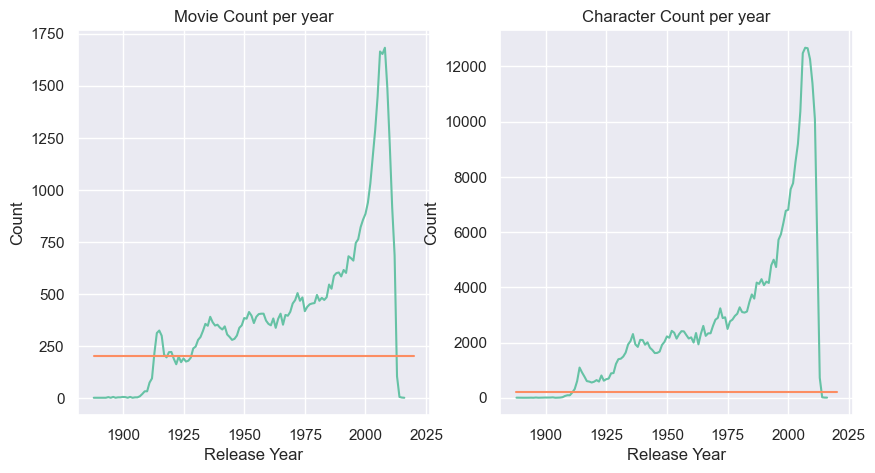

In [402]:
movie_geo_count_per_year = cmu_geo.groupby(['ReleaseYear']).agg({'WikiMovieID' : 'nunique'})
character_geo_count_per_year = cmu_geo.groupby(['ReleaseYear']).agg({'Gender': 'count'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize= (10,5))
ax1.plot(movie_geo_count_per_year)
ax1.plot([1888, 2020], [200, 200])
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Count')
ax1.set_title('Movie Count per year')

ax2.plot(character_geo_count_per_year)
ax2.plot([1888, 2020], [200, 200])
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Count')
ax2.set_title('Character Count per year')

plt.show()

In [403]:
# Keep only movies between 1930 and 2012 to have at least 200 movies per year and at least 100 characters per year
cmu_geo = cmu_geo.loc[(cmu_geo['ReleaseYear'] >= 1930) & (cmu_geo['ReleaseYear'] <= 2012)].copy(deep=True)
print(f'The cmu_geo dataset contains {len(cmu_geo.index)} entries after filtering to have at least 200 movies and 100 characters per year')

The cmu_geo dataset contains 326134 entries after filtering to have at least 200 movies and 100 characters per year


In [404]:
print('Percentage of missing entries in the cmu_geo dataset:')
print(100*cmu[['WikiMovieID', 'FreebaseMovieID', 'MovieName', 'ReleaseDate', 'BORevenue',
               'ReleaseYear', 'CharacterName','Gender', 'Ethnicity','ActorName', 'Age',
               'FreebaseCharacterID','FreebaseActorID', 'FreebaseActorMapID']].isna().sum() / len(cmu_geo))

print(f"\nLanguages {percent_missing_strdict(cmu_geo['Languages']):.2f}%") 
print(f"Countries {percent_missing_strdict(cmu_geo['Countries']):.2f}%") 
print(f"MovieGenre {percent_missing_strdict(cmu_geo['MovieGenre']):.2f}%") 

Percentage of missing entries in the cmu_geo dataset:
WikiMovieID             0.000000
FreebaseMovieID         0.000000
MovieName               0.000000
ReleaseDate             0.000000
BORevenue              87.952805
ReleaseYear             0.000000
CharacterName          61.723709
Gender                  0.000000
Ethnicity              86.002686
ActorName               0.003679
Age                    28.981646
FreebaseCharacterID    61.721256
FreebaseActorID         0.000000
FreebaseActorMapID      0.000000
dtype: float64

Languages 4.78%
Countries 0.00%
MovieGenre 0.00%


### Proportion of female per movie

We create a new dataset containing the proportion of feminine characters per movie.

In [405]:
women_characters = cmu.loc[cmu['Gender']=='F'].copy(deep=True)
men_characters = cmu.loc[cmu['Gender']=='M'].copy(deep=True)

In [406]:
#Create the dataframe
df_gender_proportion_by_movie_geo= pd.DataFrame()

#Add the number of male and female characters of each movie
df_gender_proportion_by_movie_geo['MaleCharacters'] = men_characters.groupby(['WikiMovieID'])['Gender'].count()
df_gender_proportion_by_movie_geo['FemaleCharacters'] = women_characters.groupby(['WikiMovieID'])['Gender'].count()

#Change Nan to O 
df_gender_proportion_by_movie_geo['FemaleCharacters'] = df_gender_proportion_by_movie_geo['FemaleCharacters'].replace(np.nan, 0)
df_gender_proportion_by_movie_geo['MaleCharacters'] = df_gender_proportion_by_movie_geo['MaleCharacters'].replace(np.nan, 0)

#Add the total number of characters of each movie
df_gender_proportion_by_movie_geo['TotalNumberofCharacters'] = cmu.groupby(['WikiMovieID'])['Gender'].count()

#Add the release year of each movie
df_gender_proportion_by_movie_geo = df_gender_proportion_by_movie_geo.merge(cmu[['ReleaseYear', 'WikiMovieID']], how='left', left_index=True, right_on=['WikiMovieID'] )

#Add the country & continent
df_gender_proportion_by_movie_geo = df_gender_proportion_by_movie_geo.merge(cmu_geo[['WikiMovieID', 'Continent', 'Countries']], how='left', on='WikiMovieID' )

#Calculate the proportion of male and female characters per movie
df_gender_proportion_by_movie_geo['PercentageofFemale'] = df_gender_proportion_by_movie_geo['FemaleCharacters'] / df_gender_proportion_by_movie_geo['TotalNumberofCharacters'] * 100
df_gender_proportion_by_movie_geo['PercentageofMale'] = df_gender_proportion_by_movie_geo['MaleCharacters'] / df_gender_proportion_by_movie_geo['TotalNumberofCharacters'] * 100

#Remove duplicated rows
df_gender_proportion_by_movie_geo = df_gender_proportion_by_movie_geo.drop_duplicates(subset=['WikiMovieID']).copy(deep=True)

#Reorder the columns
df_gender_proportion_by_movie_geo = df_gender_proportion_by_movie_geo[['WikiMovieID', 'ReleaseYear', 'Continent', 'Countries', 'TotalNumberofCharacters', 'MaleCharacters', 'FemaleCharacters', 'PercentageofFemale', 'PercentageofMale' ]]

display(df_gender_proportion_by_movie_geo)

,WikiMovieID,ReleaseYear,Continent,Countries,TotalNumberofCharacters,MaleCharacters,FemaleCharacters,PercentageofFemale,PercentageofMale
0,3217,1992.0,NA,US,13,10,3.0,23.076923,76.923077
169,3746,1982.0,NaN,NaN,14,11,3.0,21.428571,78.571429
183,3837,1974.0,NA,US,20,18,2.0,10.000000,90.000000
583,3947,1986.0,NA,US,15,10,5.0,33.333333,66.666667
808,4227,1975.0,NaN,NaN,9,7,2.0,22.222222,77.777778
...,...,...,...,...,...,...,...,...,...
3529109,37322106,2012.0,NaN,NaN,3,1,2.0,66.666667,33.333333
3529112,37373877,2006.0,NA,US,6,3,3.0,50.000000,50.000000
3529148,37476824,2011.0,AS,IN,10,6,4.0,40.000000,60.000000
3529248,37478048,1996.0,NaN,NaN,4,3,1.0,25.000000,75.000000


### Plot summaries

In [407]:
plot_summaries = pd.read_csv(PLOT_SUMMARIES_PATH, sep = '\t', header=None, names = ['WikiMovieID', 'Summary'])

display(plot_summaries)

,WikiMovieID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


We will calculate the sentiment score of the plot summary of each movie, which is comprised between -1 (most negative film) and +1 (most positive film). We use the spacy pipeline *spacytextblob*. We will use the sentiment score of the plot summary as a proxy for the sentiment of the movie.

In [289]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("spacytextblob")

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/spacy/util.py:910: UserWarning:

[W095] Model 'en_core_web_lg' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



In [ ]:
#Estimated run time: 35min

#Calculate the sentiment score of each movie
plot_summaries['Summary'] = plot_summaries.Summary.apply(lambda x : nlp(x))
plot_summaries['Sentiment'] = plot_summaries.Summary.apply(lambda x : x._.blob.polarity)
display(plot_summaries)

## PART 2: The Movies Dataset: find the main character <a id="part1.3"></a>

We use this dataset to find the main character of movies.

In [408]:
credits = pd.read_csv(CREDITS_PATH)
display(credits)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506


In [409]:
movies_credits = pd.read_csv(MOVIES_CREDITS_PATH)
display(movies_credits)

/var/folders/xy/g9qngpq914dbt048l9v974zh0000gn/T/ipykernel_12098/600144018.py:1: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [410]:
movies_credits['id'] = pd.to_numeric(movies_credits['id'], errors='coerce')
movies_credits = movies_credits.dropna(subset=['id'])
movies_credits['id'] = movies_credits['id'].astype(int)

In [411]:
# Merge datasets based on 'id' column with a left join
credits = pd.merge(credits, movies_credits[['id', 'title']], on='id', how='left')

# Display the merged DataFrame
display(credits)

,cast,crew,id,title
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,Toy Story
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,Jumanji
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,Grumpier Old Men
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,Waiting to Exhale
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,Father of the Bride Part II
...,...,...,...,...
45533,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050,Subdue
45534,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109,Century of Birthing
45535,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758,Betrayal
45536,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506,Satan Triumphant


In [412]:
# Convert the str-like dictionaries to dictionaries
credits['cast'] = credits['cast'].apply(ast.literal_eval)

In [413]:
credits['main_char'], credits['main_actor'], credits['main_char_gender'] = zip(*credits['cast'].apply(lambda x: find_main_char(x) if x else (None, None, None)).tolist())
display(credits)

,cast,crew,id,title,main_char,main_actor,main_char_gender
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,Toy Story,Woody (voice),Tom Hanks,2.0
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,Jumanji,Alan Parrish,Robin Williams,2.0
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,Grumpier Old Men,Max Goldman,Walter Matthau,2.0
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,Waiting to Exhale,Savannah 'Vannah' Jackson,Whitney Houston,1.0
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,Father of the Bride Part II,George Banks,Steve Martin,2.0
...,...,...,...,...,...,...,...
45533,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050,Subdue,,Leila Hatami,1.0
45534,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109,Century of Birthing,Sister Angela,Angel Aquino,1.0
45535,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758,Betrayal,Emily Shaw,Erika Eleniak,1.0
45536,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506,Satan Triumphant,,Iwan Mosschuchin,2.0


In [414]:
#Drop the movies where we don't have the main character's gender
credits = credits.dropna(subset=['main_char_gender'])
credits = credits[credits['main_char_gender'] != 0]

#Reformat the main_char_gender column with F or M
credits['main_char_gender'] = credits['main_char_gender'].map({1.0: 'F', 2.0: 'M'})
display(credits)

,cast,crew,id,title,main_char,main_actor,main_char_gender
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,Toy Story,Woody (voice),Tom Hanks,M
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,Jumanji,Alan Parrish,Robin Williams,M
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,Grumpier Old Men,Max Goldman,Walter Matthau,M
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,Waiting to Exhale,Savannah 'Vannah' Jackson,Whitney Houston,F
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,Father of the Bride Part II,George Banks,Steve Martin,M
...,...,...,...,...,...,...,...
45532,"[{'cast_id': 1, 'character': 'Sir Robert Hode'...","[{'credit_id': '52fe44439251416c9100a899', 'de...",30840,Robin Hood,Sir Robert Hode,Patrick Bergin,M
45533,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050,Subdue,,Leila Hatami,F
45534,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109,Century of Birthing,Sister Angela,Angel Aquino,F
45535,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758,Betrayal,Emily Shaw,Erika Eleniak,F


In [415]:
credits = credits.drop(['cast', 'crew'], axis=1)
display(credits)

,id,title,main_char,main_actor,main_char_gender
0,862,Toy Story,Woody (voice),Tom Hanks,M
1,8844,Jumanji,Alan Parrish,Robin Williams,M
2,15602,Grumpier Old Men,Max Goldman,Walter Matthau,M
3,31357,Waiting to Exhale,Savannah 'Vannah' Jackson,Whitney Houston,F
4,11862,Father of the Bride Part II,George Banks,Steve Martin,M
...,...,...,...,...,...
45532,30840,Robin Hood,Sir Robert Hode,Patrick Bergin,M
45533,439050,Subdue,,Leila Hatami,F
45534,111109,Century of Birthing,Sister Angela,Angel Aquino,F
45535,67758,Betrayal,Emily Shaw,Erika Eleniak,F


## PART 3: CoreNLP parsed movie summaries <a id="part1.3"></a>

We process the files contained in the corenlp_plot_summaries.tar archive.

All functions used for this part and other helpers are in the helpers_corenlp.py file.

In [416]:
# First we extract the files contained in the tar file into .xml files
load_corenlp_data()

From the Bamman et al. paper [1], we know what type of dependencies we need to look for in the plot summary trees:
- for agent verbs: verbs for which the entity is
   - nsubj
   - agent
- for patient verbs: verbs for which the entity is
   - dobj
   - nsubjpass
   - iobj
   - any prepositional argument prep_*
- for attributes: adjectives and common noun words that relate to the mention as adjecti- val modifiers, noun-noun compounds, appos- itives, or copulas: 
   - nsubj or appos governors of a character mention
   - nsubj, appos, amod, nn dependents of a character mention

This search is directly implemented in a function.

The idea is also to count the number of mentions of each character of a movie and then use this number of mentions as a proxy for identifying the main character. Thus in our case we define the main character as the moset mentioned one in the plot summary.

In [417]:
# Get the Wikipedia movie id from the Lord of the Ring movies
test_ids = characters[characters['CharacterName'] == 'Aragorn']['WikiMovieID'].values

In [418]:
# Get the main character names from the Lord of the Ring movies
for id in test_ids:
    movie_xml = str(id) + '.xml'
    print(get_main_character(movie_xml))

Frodo
Frodo Baggins
Frodo
Frodo


As we expect, we extract Frodo as the main character of all the Lord of the Ring movies.
But we see that depending on the plot summary, the character's full name extracted can be different...

We thus need to check in a bidirectional way what the "fullest" name used is between the name extracted from the summary and the one used in the character metadata before merging.

In [419]:
lst = []
# we only iterate over movies for which both character and movie metadata is available
ids = np.intersect1d(movies['WikiMovieID'].unique(), characters['WikiMovieID'].unique())
for id in ids[:100]:
    # We extract the data from the .xml files into a list of dictionaries
    if os.path.isfile(CORE_NLP_XML + '/' + str(id) + '.xml'):
        lst = lst + get_list_movie(str(id) + '.xml')
        cmu_characters = list(cmu[cmu['WikiMovieID'] == id].CharacterName)
        xml_characters = list(get_characters_from_xml(str(id) + '.xml'))
        characters = cmu_characters + xml_characters
        # type cast to string
        characters = [str(x) for x in characters]
        # get the full names of the characters
        full_names_dict = get_full_names_dict(characters)
        # replace cmu CharacterName by the full name in that movie
        cmu.loc[cmu['WikiMovieID'] == id, 'CharacterName'] = cmu.loc[cmu['WikiMovieID'] == id, 'CharacterName'].apply(lambda x: full_names_dict[x] if x in full_names_dict.keys() else x)

# We convert the list of dictionaries into a dataframe
df_corenlp = pd.DataFrame(lst)
df_corenlp.head()

,WikiMovieID,CharacterName,Agent verbs,Patient verbs,Attributes,Mentions,MainCharacter
0,3217,Lord Arthur,[],[],[],3,False
1,3217,Henry,[],"{ set, enslaved}",[],2,False
2,3217,Sheila,[],"{ captured, transformed, attracted, saving}",[],4,True
3,3217,Ash,{slays},"{ determined, celebrated, pursues, thrown, ...",[],2,False
4,3217,Klaatu,[],{say},[],1,False


The code takes a lot of time to run so for now we only do it for a few movies (for the first 100 IDs).

We need to typecast so that we can merge!

In [420]:
# Change the type of the WikiMovieID column to int64
df_corenlp['WikiMovieID'] = df_corenlp['WikiMovieID'].astype('int64')

In [421]:
cmu_corenlp = cmu.merge(df_corenlp, how='inner', on=['WikiMovieID', 'CharacterName'])

In [422]:
cmu_corenlp.head()

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,CharacterName,...,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,Agent verbs,Patient verbs,Attributes,Mentions,MainCharacter
0,8695,/m/02dwj,Dr. Strangelove or: How I Learned to Stop Worr...,1964-01-29,9164370.0,"{'/m/02h40lc': 'English Language', '/m/06b_j':...",{'/m/07ssc': 'United Kingdom'},{'/m/07s9rl0': 'Drama'},1964.0,Dr. Strangelove,...,Peter Sellers,38.0,/m/02nwt1n,/m/02nwt1q,/m/063_t,[],[],[],3,False
1,8695,/m/02dwj,Dr. Strangelove or: How I Learned to Stop Worr...,1964-01-29,9164370.0,"{'/m/02h40lc': 'English Language', '/m/06b_j':...",{'/m/07ssc': 'United Kingdom'},{'/m/07s9rl0': 'Drama'},1964.0,Merkin Muffley,...,Peter Sellers,38.0,/m/05dc8rr,/m/02s2g7,/m/063_t,{gives},{shocked},[],5,False
2,30575,/m/07j6w,Twelve Monkeys,1995-12-27,168839459.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},1995.0,James Cole,...,Bruce Willis,40.0,/m/0k7f2_,/m/04drwvq,/m/0h7pj,{witnessing},"{ gives, interviewed, troubled, locked, res...","{ young, living}",6,True
3,30575,/m/07j6w,Twelve Monkeys,1995-12-27,168839459.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},1995.0,Dr. Kathryn Railly,...,Madeleine Stowe,37.0,/m/0k7f34,/m/0h2ldj5,/m/01xldv,{spots},{kidnaps},[],6,False
4,30575,/m/07j6w,Twelve Monkeys,1995-12-27,168839459.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},1995.0,Jeffrey Goines,...,Brad Pitt,32.0,/m/0k7f39,/m/04dk4xh,/m/0c6qh,{suggests},{encounters},[],5,False


We get a dataframe with character information extracted from the movie plot summary joined with metadata from the CMU movie corpus. The information extracted from the CoreNLP parsed summaries will be used to cluster characters based on their depiction in the summary.

## PART 4: IMDB datasets <a id="part1.3"></a>

This dataset contains ratings of movies. Grades are given by the IMDB users.

In [423]:
# Load the datasets
IMDB_title = pd.read_csv(IMDB_BASICS_PATH,sep='\t', low_memory=False)
IMDB_ratings = pd.read_csv(IMDB_RATINGS_PATH, sep = '\t')

In [424]:
display(IMDB_title)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10295872,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10295873,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10295874,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10295875,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [425]:
display(IMDB_ratings)

,tconst,averageRating,numVotes
0,tt0000001,5.7,2005
1,tt0000002,5.8,269
2,tt0000003,6.5,1908
3,tt0000004,5.5,178
4,tt0000005,6.2,2688
...,...,...,...
1366964,tt9916730,7.6,11
1366965,tt9916766,7.0,22
1366966,tt9916778,7.2,36
1366967,tt9916840,8.8,6


The dataset contains rates of other audiovisual formats than movie. We will only keep the movies. 

In [426]:
# Only choose the rows which correspond to data of a movie
IMDB_title = IMDB_title[IMDB_title['titleType'] == 'movie'].copy(deep=True)

# Merge the dataset with the titles and the dataset with the ratings
df_IMDB = IMDB_title.merge(IMDB_ratings, left_on='tconst', right_on='tconst')
display(df_IMDB)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,207
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.3,484
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.1,15
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,855
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.0,21
...,...,...,...,...,...,...,...,...,...,...,...
299653,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84,Thriller,5.8,1448
299654,tt9916362,movie,Coven,Akelarre,0,2020,\N,92,"Drama,History",6.4,5605
299655,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,\N,\N,"Adventure,History,War",3.5,17
299656,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123,Drama,8.6,7


Let's check if there are aberrant values in the averageRating column, for example negative values or values higher than 10.

In [427]:
df_IMDB.describe()

,averageRating,numVotes
count,299658.000000,2.996580e+05
mean,6.175995,3.619263e+03
std,1.370387,3.570741e+04
min,1.000000,5.000000e+00
25%,5.300000,1.900000e+01
50%,6.300000,6.100000e+01
75%,7.100000,3.130000e+02
max,10.000000,2.816055e+06


There are no aberrant values in the averageRating column.

### Calculate the average rating of each movie

We want to have the average rating of each movie. In df_IMDB, we have several ratings for each movies; indeed, the same movie (characterized by its 'orginialTitle') has a grade for each 'primaryTitle' used.
In the calculation of the average rating per originalTitle, we will ponderate the rating per primaryTitle with the number of votes per primaryTitle.
Then, we will calculate the average rating across all primaryTitle i for an originalTitle as :  
$Average\, Rating\, of\, originalTitle =\frac{\sum {average\,rating\,of\,primaryTitle(i) \times number\,of\,votes\,of\,primaryTitle(i)}} {\sum{number\,of\,votes\,of\,primaryTitle(i)}}$

In [428]:
# Create datasets of average ratings of a movie considering the ratings of movies with titles in different languages

# Calculate average_rating_language(i) * number_of_votes_language(i) (ponderate)
df_IMDB['mult_ratings'] = df_IMDB['averageRating']*df_IMDB['numVotes']

average_ratings = pd.DataFrame()
average_ratings['sum_of_mult_ratings'] = df_IMDB[['originalTitle', 'mult_ratings']].groupby('originalTitle').sum()
average_ratings['total_vote'] = df_IMDB[['originalTitle', 'numVotes']].groupby('originalTitle').sum()
average_ratings['total_average_rating'] = average_ratings['sum_of_mult_ratings']/average_ratings['total_vote']

average_ratings = average_ratings.reset_index(level=0)

# Create a new dataframe with the movies primary titles, release years, and average ratings.
ratings = df_IMDB.merge(average_ratings[['total_average_rating', 'originalTitle', 'total_vote']], how = 'left', on = 'originalTitle')
ratings=ratings[['primaryTitle', 'startYear', 'total_average_rating', 'total_vote']]
ratings=ratings.drop_duplicates(subset=['primaryTitle', 'startYear' ]).copy(deep=True)

# Prepare the dataset to be merged with CMU movies.
ratings= ratings.rename(columns = {"primaryTitle" : "MovieName", "startYear" : "ReleaseYear", "total_average_rating" : "AverageRating", "total_vote" : "NumberofVotes"})
ratings["ReleaseYear"]=pd.to_datetime(ratings["ReleaseYear"], errors='coerce').dt.year

display(ratings)

,MovieName,ReleaseYear,AverageRating,NumberofVotes
0,Miss Jerry,1894.0,5.300000,207
1,The Corbett-Fitzsimmons Fight,1897.0,5.300000,484
2,Bohemios,1905.0,4.285714,28
3,The Story of the Kelly Gang,1906.0,6.000000,855
4,The Prodigal Son,1907.0,5.036364,33
...,...,...,...,...
299652,Safeguard,2020.0,3.700000,245
299653,Il talento del calabrone,2020.0,5.800000,1448
299655,The Secret of China,2019.0,3.500000,17
299656,Kuambil Lagi Hatiku,2019.0,8.600000,7


### Merge with the CMU movies dataset

We populate our movies dataset with the available movie ratings. 

In [429]:
ratings = cmu.merge(ratings, on=["MovieName", "ReleaseYear"], how='left' ).copy(deep=True)
display(ratings)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,AverageRating,NumberofVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Akooshay,F,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,4.9,56894.0
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Lieutenant Melanie Ballard,F,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,4.9,56894.0
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Desolation Williams,M,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,4.9,56894.0
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Sgt Jericho Butler,M,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,4.9,56894.0
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Bashira Kincaid,F,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,4.9,56894.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380817,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},{'/m/03k9fj': 'Adventure'},1992.0,Hibiki,M,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN,NaN
380818,12476867,/m/02w7zz8,Spliced,2002,NaN,{'/m/02h40lc': 'English Language'},{'/m/0d060g': 'Canada'},{'/m/01jfsb': 'Thriller'},2002.0,NaN,F,/m/041rx,Liane Balaban,21.0,/m/03jpb_5,NaN,/m/02pn4z4,NaN,NaN
380819,12476867,/m/02w7zz8,Spliced,2002,NaN,{'/m/02h40lc': 'English Language'},{'/m/0d060g': 'Canada'},{'/m/01jfsb': 'Thriller'},2002.0,NaN,M,/m/041rx,Ron Silver,55.0,/m/04hv69s,NaN,/m/03swmf,NaN,NaN
380820,12476867,/m/02w7zz8,Spliced,2002,NaN,{'/m/02h40lc': 'English Language'},{'/m/0d060g': 'Canada'},{'/m/01jfsb': 'Thriller'},2002.0,NaN,F,NaN,Siri Baruc,24.0,/m/0gc8cd7,NaN,/m/0gbwvjl,NaN,NaN


In [430]:
print('Percentage of missing entries in the ratings dataset:\n', 100*ratings[['AverageRating', 'NumberofVotes']].isna().sum() / len(ratings))

Percentage of missing entries in the ratings dataset:
 AverageRating    33.033806
NumberofVotes    33.033806
dtype: float64


## PART 5: Oscars datasets <a id="part1.4"></a>

In [431]:
awards = pd.read_csv(AWARDS_PATH, names = ['ReleaseYear','CeremonyYear' ,'Ceremony','Category','NomineeName',
                                                                      'MovieName','Winner'], skiprows=1)

display(awards)

,ReleaseYear,CeremonyYear,Ceremony,Category,NomineeName,MovieName,Winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10760,2022,2023,95,HONORARY AWARD,"To Euzhan Palcy, a masterful filmmaker who bro...",NaN,True
10761,2022,2023,95,HONORARY AWARD,"To Diane Warren, for her genius, generosity an...",NaN,True
10762,2022,2023,95,HONORARY AWARD,"To Peter Weir, a fearless and consummate filmm...",NaN,True
10763,2022,2023,95,GORDON E. SAWYER AWARD,Iain Neil,NaN,True


In [432]:
print('Percentage of missing entries in the awards dataset:\n', 100*awards[['ReleaseYear', 'CeremonyYear', 'Ceremony', 'Category', 'NomineeName', 'MovieName', 'Winner']].isna().sum() / len(awards))

Percentage of missing entries in the awards dataset:
 ReleaseYear     0.000000
CeremonyYear    0.000000
Ceremony        0.000000
Category        0.000000
NomineeName     0.037157
MovieName       2.926150
Winner          0.000000
dtype: float64


We remove lines where we lack the nominee name and movie name

In [433]:
awards = awards.drop(awards[awards['MovieName'].isnull()].index).copy(deep=True)
awards = awards.drop(awards[awards['NomineeName'].isnull()].index).copy(deep=True)

print(f'After filtering, we are left with {len(awards.index)} entries')

After filtering, we are left with 10450 entries


In [434]:
common_films = len(set(awards['MovieName']) & set(cmu['MovieName']))
print('Percentage of common films between the awards and CMU movies compared to total CMU: ', 100*common_films/len(cmu['MovieName']))
print('Percentage of common films between the awards and CMU movies compared to total awards: ',100*common_films/len(awards['MovieName']))

Percentage of common films between the awards and CMU movies compared to total CMU:  0.8106149329608059
Percentage of common films between the awards and CMU movies compared to total awards:  29.54066985645933


# STEP 2: DATA ANALYSIS <a id="Data-analysis"></a>

---

## PART 1: Quantitative analysis of gender inequalities in movies <a id="part2.1"></a>

We will start by analysing the main differences we can find between the representation of men and women in the movie industry.

### AGE: IS THERE A DIFFERENCE ?

We often hear clichés about the evolution of beauty with age: women are described as blossoming in their youth, while men become more handsome with age. An intriguing question arises: does this perceived divergence in the aesthetics of aging manifest itself in the film industry, and if so, is this disparity statistically significant? 

Let's explore the data !

In [317]:
# Set the plot style and color palette
sns.set(style="darkgrid", palette="Set2")

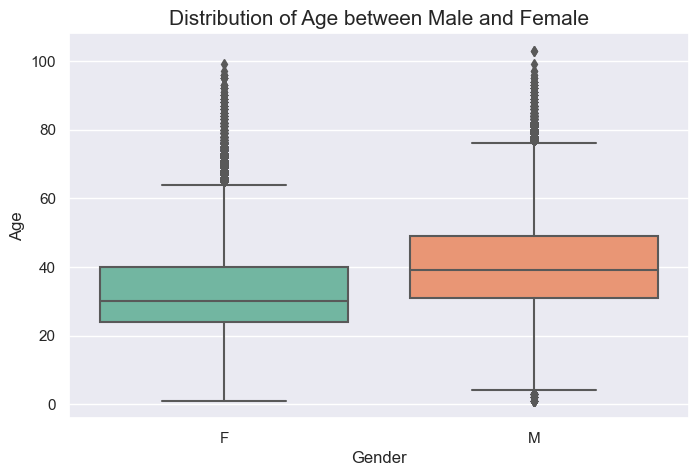

In [318]:
plt.figure(figsize=(8, 5))

sns.boxplot(x='Gender', y='Age', data=cmu)
plt.title('Distribution of Age between Male and Female', fontsize=15)

plt.xlabel('Gender', fontsize=12)
plt.ylabel('Age', fontsize=12)

plt.show()

In [325]:
mean_age_women = women_characters['Age'].mean()
mean_age_men = men_characters['Age'].mean()
mean_diff_age = mean_age_men - mean_age_women

print(f'The average age of actresses in movies is {mean_age_women:.2f} years old.')
print(f'The average age of actors in movies is {mean_age_men:.2f} years old.')
print(f'The average age difference between actors and actresses in movies is {mean_diff_age:.2f} years old.')

The average age of actresses in movies is 33.07 years old.
The average age of actors in movies is 40.52 years old.
The average age difference between actors and actresses in movies is 7.45 years old.


In [320]:
# T-test to determine if the difference in age between men and women is statistically significant 
stats.ttest_ind(women_characters['Age'], men_characters['Age'], nan_policy='omit')

TtestResult(statistic=-138.82309444571388, pvalue=0.0, df=286301.0)

We used a two-sided t-test for the null hypothesis that the age of actors and actresses have identical average (expected) values. The p-value is much smaller than 0.05, therefore we can reject the null hypothesis, meaning that there is a statistically significant difference in the average ages between the two groups. As the t-statistic is strongly negative (-104), it supports our conclusion that women are significantly younger than men.

### Has this tendency evolved with years ?

First, we check that we have at least 100 ages per year in the women and men datasets.

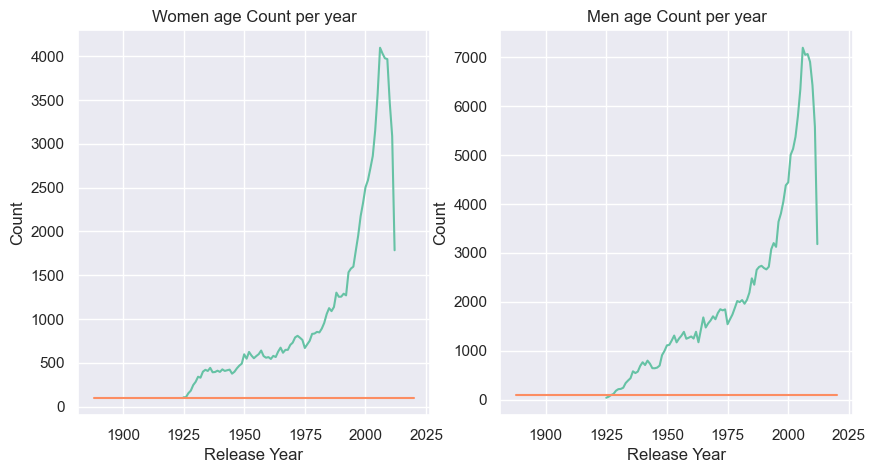

In [326]:
#Do we have enough information per year?
women_count_age_per_year = women_characters.groupby('ReleaseYear').agg({'Age': 'count'})
men_count_age_per_year = men_characters.groupby('ReleaseYear').agg({'Age': 'count'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize= (10,5))
ax1.plot(women_count_age_per_year)
ax1.plot([1888, 2020], [100, 100])
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Count')
ax1.set_title('Women age Count per year')

ax2.plot(men_count_age_per_year)
ax2.plot([1888, 2020], [100, 100])
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Count')
ax2.set_title('Men age Count per year')

plt.show()

In [327]:
display(men_count_age_per_year)

,Age
ReleaseYear,
1925.0,36
1926.0,58
1927.0,91
1928.0,115
1929.0,180
...,...
2008.0,7065
2009.0,6905
2010.0,6426


For the men we don't have enough data before 1928; thus we will do the analysis with movies released after 1927.

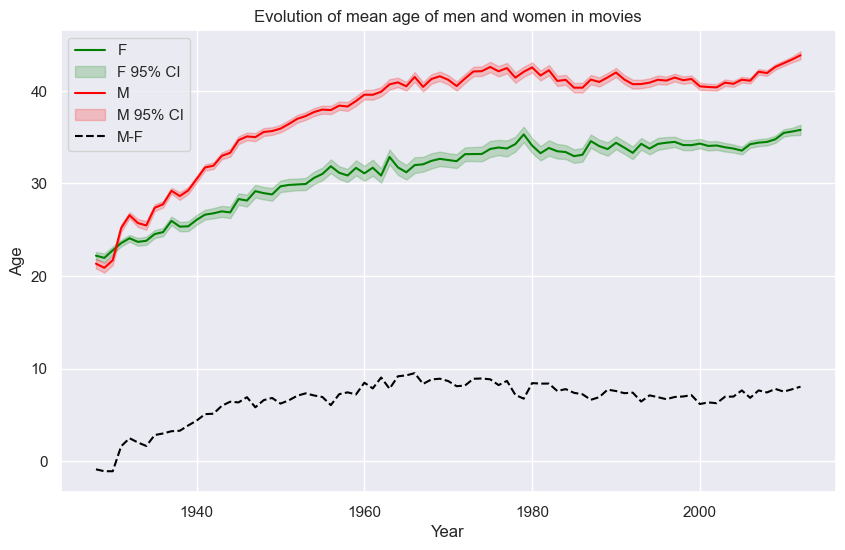

In [330]:
# Calculate the average age of actors and actresses in movies across year
women_mean_age_per_year, men_mean_age_per_year = women_characters.groupby('ReleaseYear').agg({'Age': 'mean'}), men_characters.groupby('ReleaseYear').agg({'Age': 'mean'})

# Calculate the 95% CIs
women_std_age_per_year, men_std_age_per_year= women_characters.groupby('ReleaseYear').agg({'Age': 'std'}), men_characters.groupby('ReleaseYear').agg({'Age': 'std'})

z=1.96

to_add_women = z*women_std_age_per_year['Age']/np.sqrt(women_characters.groupby('ReleaseYear').agg({'Gender' : 'count'})['Gender'])
upper_bound_women, lower_bound_women = women_mean_age_per_year['Age'] + to_add_women, women_mean_age_per_year['Age'] - to_add_women

to_add_men = z*men_std_age_per_year['Age']/np.sqrt(men_characters.groupby('ReleaseYear').agg({'Gender' : 'count'})['Gender'])
upper_bound_men, lower_bound_men = men_mean_age_per_year['Age'] + to_add_men, men_mean_age_per_year['Age'] - to_add_men

# Plot the evolution of mean age of men and women in movies
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(women_mean_age_per_year[1928:], label='F', color='green')
ax.fill_between(women_mean_age_per_year[1928:].index, lower_bound_women[1928:], upper_bound_women[1928:], alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(men_mean_age_per_year[1928:], label='M', color='red')
ax.fill_between(men_mean_age_per_year[1928:].index, lower_bound_men[1928:], upper_bound_men[1928:], alpha =0.2, color='red', label = 'M 95% CI')

ax.plot(men_mean_age_per_year[1928:]-women_mean_age_per_year[1928:], label='M-F', color='k', linestyle='--')

#ax.set_ylim(10,47)
ax.set_xlabel('Year')
ax.set_ylabel('Age')
ax.set_title('Evolution of mean age of men and women in movies')
ax.legend()

plt.show()

### PROPORTION OF FEMALE CHARACTERS

We will explore the proportion of female characters in movies. Therefore, we first create a new dataframe containing the number and percentage of men and women per movie and the release year of the movie.

Now we can compare the distributions of the percentages of female and male characters per movie.

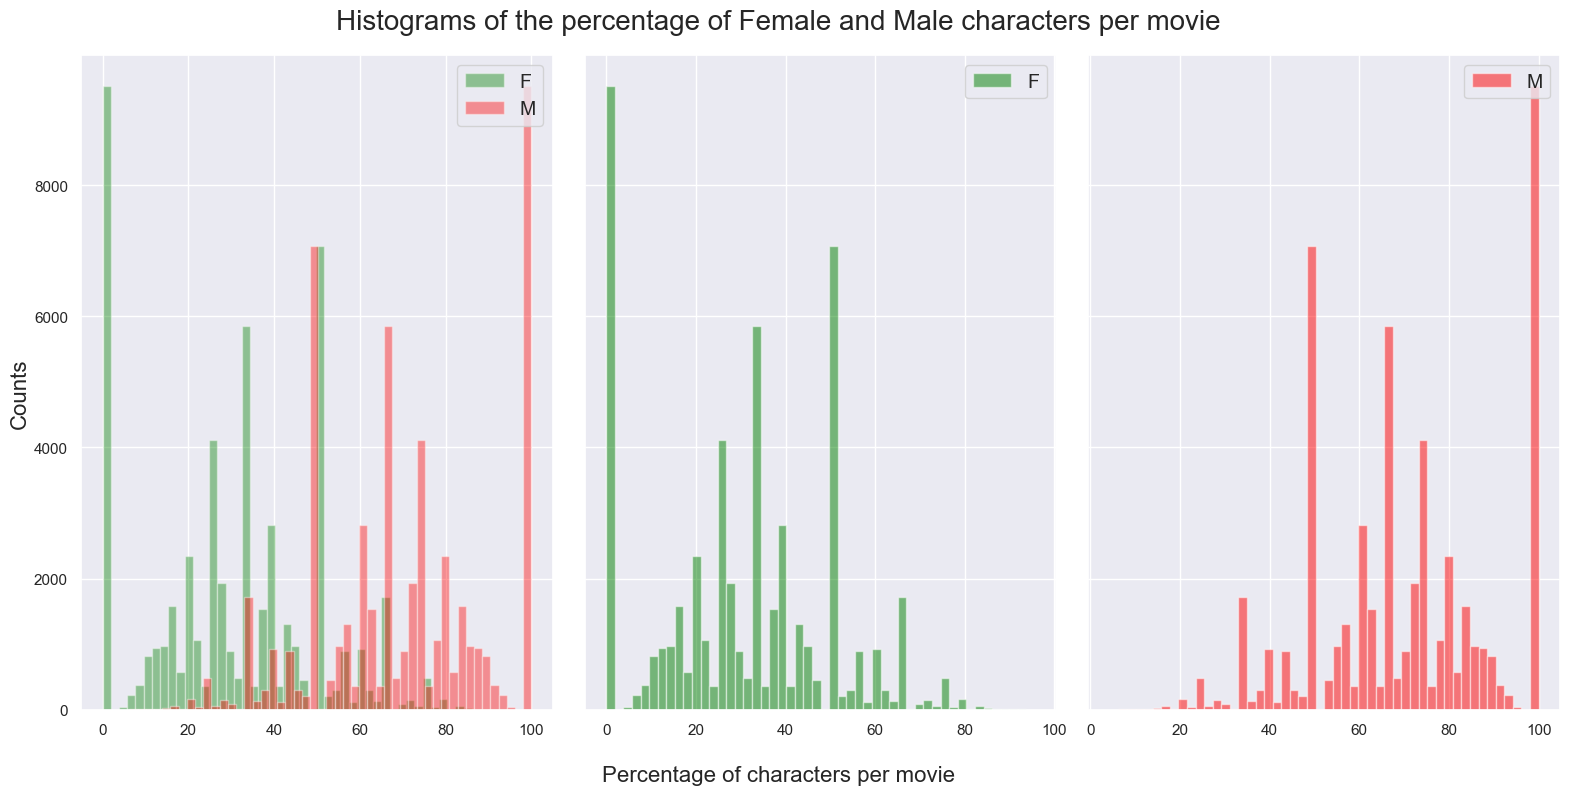

In [331]:
#Plot
fig, ax = plt.subplots(1, 3, figsize=(16,8), sharey=True)

ax[0].hist(df_gender_proportion_by_movie_geo['PercentageofFemale'], bins=50, label='F', alpha=0.4, color='green')
ax[0].hist(df_gender_proportion_by_movie_geo['PercentageofMale'], bins=50, label='M', alpha=0.4, color='red')
ax[0].legend(loc='upper right', fontsize=14) 

ax[1].hist(df_gender_proportion_by_movie_geo['PercentageofFemale'], bins=50, label='F', alpha=0.5, color='green')
ax[1].legend(loc='upper right', fontsize=14) 

ax[2].hist(df_gender_proportion_by_movie_geo['PercentageofMale'], bins=50, label='M', alpha=0.5, color='red')
ax[2].legend(loc='upper right', fontsize=14) 

fig.supxlabel('Percentage of characters per movie', fontsize=16)
fig.supylabel('Counts', va='center', rotation=90, fontsize=16)
fig.suptitle('Histograms of the percentage of Female and Male characters per movie', fontsize=20)

plt.tight_layout()

plt.show()

In [332]:
mean_perc_women = df_gender_proportion_by_movie_geo['PercentageofFemale'].mean()
mean_perc_men = df_gender_proportion_by_movie_geo['PercentageofMale'].mean()
mean_diff_perc = mean_perc_men - mean_perc_women

print(f'The average percentage of actresses in movies is {mean_perc_women:.2f}%.')
print(f'The average percentage of actors in movies is {mean_perc_men:.2f}%.')
print(f'The average percentage difference between actors and actresses in movies is {mean_diff_perc:.2f}%.')

The average percentage of actresses in movies is 30.18%.
The average percentage of actors in movies is 69.82%.
The average percentage difference between actors and actresses in movies is 39.64%.


We can see that the female distirbution is centered around values inferior to 50%, while the men distribution is centered around values superior to 50%.
We can test if the difference of mean percentage is significantly different at the 0.05 level.

In [108]:
# T-test to determine if the difference between the percentage of male and female character per movie is statistically significant. 
stats.ttest_ind(df_gender_proportion_by_movie_geo['PercentageofFemale'], df_gender_proportion_by_movie_geo['PercentageofMale'], nan_policy='omit')

TtestResult(statistic=-292.191991086202, pvalue=0.0, df=89552.0)

The p-value is smaller than 0.05, therefore the difference is statistically significant; the value of the t-test indicates that there are significantly less female than male characters per movie.

Is this tendency constant across years?

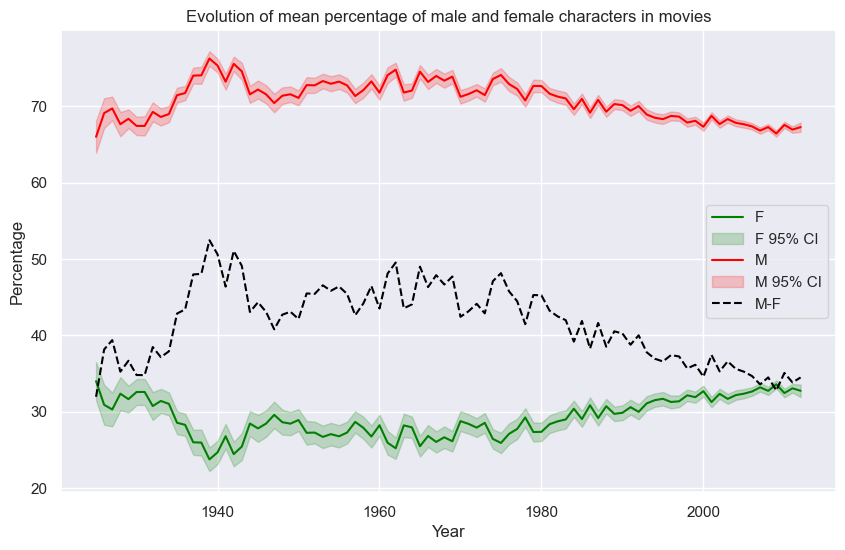

In [336]:
#Calculate the mean percentage of actors and actresses in movies across year
percentage_of_women_by_movie_geo, percentage_of_men_by_movie_geo = df_gender_proportion_by_movie_geo.groupby('ReleaseYear').agg({'PercentageofFemale':'mean'}), df_gender_proportion_by_movie_geo.groupby('ReleaseYear').agg({'PercentageofMale':'mean'})

#Calculate the 95% CIs
women_std_perc_per_year_geo, men_std_perc_per_year_geo = df_gender_proportion_by_movie_geo.groupby('ReleaseYear').agg({'PercentageofFemale':'std'}), df_gender_proportion_by_movie_geo.groupby('ReleaseYear').agg({'PercentageofMale':'std'})

z=1.96

to_add_women = z*women_std_perc_per_year_geo['PercentageofFemale']/np.sqrt(women_characters.groupby('ReleaseYear').agg({'Gender': 'count'})['Gender'])
upper_bound_women_geo, lower_bound_women_geo = percentage_of_women_by_movie_geo['PercentageofFemale'] + to_add_women, percentage_of_women_by_movie_geo['PercentageofFemale'] - to_add_women

to_add_men = z*men_std_perc_per_year_geo['PercentageofMale']/np.sqrt(men_characters.groupby('ReleaseYear').agg({'Gender': 'count'})['Gender'])
upper_bound_men_geo, lower_bound_men_geo  = percentage_of_men_by_movie_geo['PercentageofMale'] + to_add_men, percentage_of_men_by_movie_geo['PercentageofMale'] - to_add_men

#Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(percentage_of_women_by_movie_geo, label='F', color='green')
ax.fill_between(lower_bound_women_geo.index, lower_bound_women_geo, upper_bound_women_geo, alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(percentage_of_men_by_movie_geo, label='M', color='red')
ax.fill_between(lower_bound_men_geo.index, lower_bound_men_geo, upper_bound_men_geo, alpha =0.2, color='red', label = 'M 95% CI')
# EB: ca ne marche pas mais jsp pourquoi?
ax.plot(percentage_of_men_by_movie_geo['PercentageofMale']-percentage_of_women_by_movie_geo['PercentageofFemale'], label='M-F', color='k', linestyle='--')


#ax.set_ylim(0,80)
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Evolution of mean percentage of male and female characters in movies')
ax.legend()
plt.show()

The confidence intervals don't overlap: across years, there is always a significantly smaller percentage of female than male characters per movie.
However, this difference seems to decrease since 1980. 

### GENRE OF MOVIE: IS THERE A DIFFERENCE ?

An often-repeated stereotype regarding women suggests that they are not inclined towards action, sports, or intellectual pursuits, but rather, their primary role is portrayed as being centered around romantic relationships. We aim to investigate whether this stereotype is reflected in the portrayal of women in movies from our dataset.

For the analysis we consider only movies that are in the 16 major movie genres of our dataset.

In [339]:
# List of rows to drop 
rows_to_drop = []

cmu_16_genre = cmu.copy()

for index, row in cmu_16_genre.iterrows():
    movie_genre = row['MovieGenre']
    
    # Drop the row if not in the 16 major genre
    if list(movie_genre.values())[0] not in major_16_genres:
        rows_to_drop.append(index)

# Modify cmu_16_genre to keep only movies that are in the 16 major genres
cmu_16_genre = cmu_16_genre.drop(rows_to_drop)
movie_counts = cmu_16_genre['WikiMovieID'].nunique()
print(f'We are left with {movie_counts} movies')

We are left with 51183 movies


To facilitate analysis, we replace the dictionary for the 'MovieGenre' column with a str:

In [340]:
cmu_16_genre['MovieGenre'] = cmu_16_genre['MovieGenre'].apply(lambda x: list(x.values())[0])

In [341]:
cmu_16_genre = pd.merge(cmu_16_genre, df_gender_proportion_by_movie_geo, on = ['WikiMovieID'], how = 'left')

Is there a difference in actors' ages between genres? 

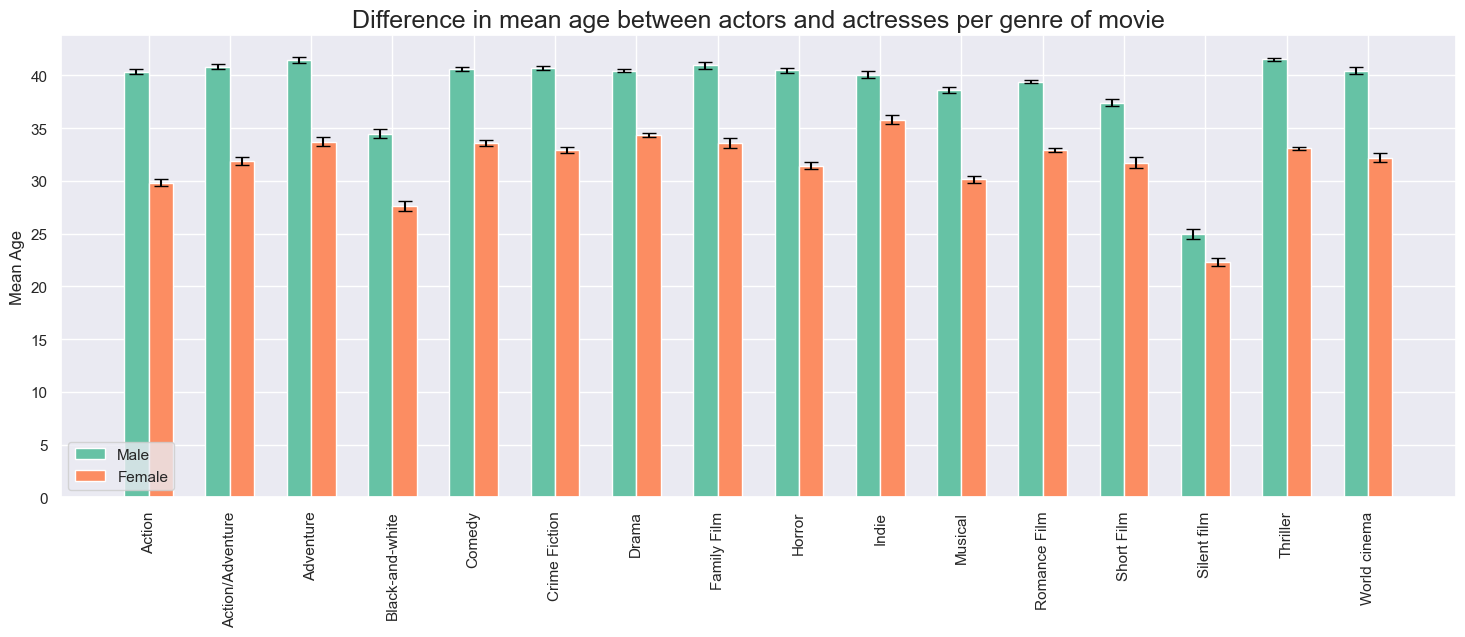

In [342]:
cmu_by_genre = cmu_16_genre.groupby('MovieGenre')

N = len(cmu_by_genre.groups.keys()) # Number of main genre of movies
ind = np.arange(N)
width = 0.3

mean_ages_M, mean_ages_F, movie_genres = [], [], []
for genre in cmu_by_genre.groups.keys():
    # Compute the mean age for actor and actresses for each movie genre
    mean_age_M_genre = np.mean(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender']=='M']['Age'])
    mean_age_F_genre = np.mean(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender']=='F']['Age'])

    mean_ages_M.append(mean_age_M_genre)
    mean_ages_F.append(mean_age_F_genre)
    movie_genres.append(genre)

# Calculate the standard error of the mean for each movie genre
serr_ages_M = [np.std(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender'] == 'M']['Age']) /
              np.sqrt(len(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender'] == 'M'])) for genre in cmu_by_genre.groups.keys()]

serr_ages_F = [np.std(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender'] == 'F']['Age']) /
              np.sqrt(len(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender'] == 'F'])) for genre in cmu_by_genre.groups.keys()]

plt.figure(figsize=(18,6))

plt.bar(ind, mean_ages_M , width, label='Male', yerr=1.96*np.array(serr_ages_M), capsize=5)
plt.bar(ind + width, mean_ages_F, width, label='Female', yerr=1.96*np.array(serr_ages_F), capsize=5)

plt.ylabel('Mean Age')
plt.title('Difference in mean age between actors and actresses per genre of movie', fontsize=18)
plt.xticks(ind + width / 2, movie_genres, rotation=90)
plt.legend(loc='best')

plt.show()

Across all genres we observe a similar inequality in the average age of actors and actresses. Actresses are generally younger in all movie genres and the difference is significant when looking at the small 95 % confidence intervals

### SENTIMENT ANALYSIS

Now we will explore how the gender representation in movies in terms of gender of the main character and percentage of actresses vs actors in a movie can influence the general sentiment of the movie. The sentiment is represented by a score between -1 and 1, -1 being the more negative a movie can be and 1 the more positive.

However, it's important to note that the sentiment of a movie isn't solely determined by the gender representation of its cast. Other factors like storytelling, direction, screenplay, and character development significantly contribute to the overall emotional impact. A film with a male-dominated cast can still portray a wide range of sentiments, from positive to negative, based on its narrative choices and character arcs.  
Moreover, we use the sentiment of the movie plot summary as a proxy to the sentiment of the movie; this could induce potential biases.

#### Gender of the main character vs plot summary sentiment

Let's delve into the relationship between the gender of the main character and the overall sentiment of a movie: Does a film centered around a female protagonist evoke a distinct sentiment compared to one led by a male protagonist? If so, does this difference tend towards a more or less positive portrayal?

In [115]:
#Get the main character and its gender, the production country and the release year
plot_summaries_main_char = pd.merge(plot_summaries, cmu_geo[['WikiMovieID', 'MovieName', 'ActorName', 'ReleaseYear', 'MovieGenre', 'Countries']], on = 'WikiMovieID', how='inner')
plot_summaries_main_char = pd.merge(plot_summaries_main_char, credits[['title', 'main_char_gender', 'main_actor']], left_on = ['MovieName', 'ActorName'], right_on = ['title', 'main_actor'], how='inner')
plot_summaries_main_char = plot_summaries_main_char.drop(['title', 'main_actor'], axis=1)

#Duplicates can appear if an actor had several roles in the same movie, so we drop the duplicated rows.
plot_summaries_main_char = plot_summaries_main_char.drop_duplicates(subset='WikiMovieID')

display(plot_summaries_main_char)

,WikiMovieID,Summary,Sentiment,MovieName,ActorName,ReleaseYear,MovieGenre,Countries,main_char_gender,main_actor
0,31186339,"(The, nation, of, Panem, consists, of, a, weal...",0.045261,The Hunger Games,Jennifer Lawrence,2012.0,{'/m/03btsm8': 'Action/Adventure'},US,F,Jennifer Lawrence
1,1952976,"({, {, plot, }, }, The, film, opens, in, 1974,...",0.025839,Dark Water,Jennifer Connelly,2005.0,{'/m/01jfsb': 'Thriller'},US,F,Jennifer Connelly
2,2462689,"(Infuriated, at, being, told, to, write, one, ...",0.037964,Meet John Doe,Barbara Stanwyck,1941.0,{'/m/01g6gs': 'Black-and-white'},US,F,Barbara Stanwyck
3,1335380,"(The, film, is, based, on, the, events, that, ...",0.026543,Exodus,Paul Newman,1960.0,{'/m/03btsm8': 'Action/Adventure'},US,M,Paul Newman
4,1480747,"({, {, plot, }, }, Following, the, sudden, dea...",0.070732,House Party 2,Martin Lawrence,1991.0,{'/m/01z4y': 'Comedy'},US,M,Martin Lawrence
...,...,...,...,...,...,...,...,...,...,...
12227,27978238,"(In, 1864, ,, Union, army, officer, Capt, ., J...",-0.071930,Westbound,Randolph Scott,1959.0,{'/m/0hfjk': 'Western'},US,M,Randolph Scott
12228,4913923,"(In, Northern, Norway, during, the, 1860s, ,, ...",-0.000852,I Am Dina,Maria Bonnevie,2002.0,{'/m/07s9rl0': 'Drama'},FR,F,Maria Bonnevie
12229,26261438,"(While, drinking, alone, one, night, and, remi...",0.022576,Outlaw of Gor,Jack Palance,1989.0,{'/m/03k9fj': 'Adventure'},US,M,Jack Palance
12230,17208834,"(A, high, school, prom, in, Georgia, is, unexp...",-0.048327,Dance of the Dead,Jared Kusnitz,2008.0,{'/m/03npn': 'Horror'},US,M,Jared Kusnitz


##### Matching

To conduct a causal analysis, we begin by constructing pairs of movies wherein the main character's gender is the differing factor. This entails matching films precisely in terms of their genre, production country, and release period.

By creating these matched pairs, we aim to isolate the influence of the main character's gender while holding constant other significant variables such as genre (e.g., action, drama, comedy), production country (e.g., USA, France, Japan), and release period (e.g., 5-years window). This method allows us to scrutinize whether any observed differences in sentiment can be attributed primarily to the main character's gender rather than other contextual factors.

In [118]:
# Create bins for every 5 years starting from the minimum release year to the maximum release year
plot_summaries_main_char = create_bins_of_5_years(plot_summaries_main_char).copy(deep=True)

In [119]:
#Separate the dataframe depending on the main character's gender
plot_summaries_main_char_M = plot_summaries_main_char[plot_summaries_main_char['main_char_gender'] == 'M']
plot_summaries_main_char_F = plot_summaries_main_char[plot_summaries_main_char['main_char_gender'] == 'F']

In [345]:
#Estimated run time: 12min

#Match exactly on the movie genre, production country and release-year window
exact_match_columns = ['ReleaseYearBin', 'MovieGenre', 'Countries']
pair_summaries = create_pairs(exact_match_columns, plot_summaries_main_char_M, plot_summaries_main_char_F)
print('The number of matching pairs is:', len(pair_summaries))

Row 1 out of 8611
Row 2 out of 8611
Row 3 out of 8611
Row 4 out of 8611
Row 5 out of 8611
Row 6 out of 8611
Row 7 out of 8611
Row 8 out of 8611
Row 9 out of 8611
Row 10 out of 8611
Row 11 out of 8611
Row 12 out of 8611
Row 13 out of 8611
Row 14 out of 8611
Row 15 out of 8611
Row 16 out of 8611
Row 17 out of 8611
Row 18 out of 8611
Row 19 out of 8611
Row 20 out of 8611
Row 21 out of 8611
Row 22 out of 8611
Row 23 out of 8611
Row 24 out of 8611
Row 25 out of 8611
Row 26 out of 8611
Row 27 out of 8611
Row 28 out of 8611
Row 29 out of 8611
Row 30 out of 8611
Row 31 out of 8611
Row 32 out of 8611
Row 33 out of 8611
Row 34 out of 8611
Row 35 out of 8611
Row 36 out of 8611
Row 37 out of 8611
Row 38 out of 8611
Row 39 out of 8611
Row 40 out of 8611
Row 41 out of 8611
Row 42 out of 8611
Row 43 out of 8611
Row 44 out of 8611
Row 45 out of 8611
Row 46 out of 8611
Row 47 out of 8611
Row 48 out of 8611
Row 49 out of 8611
Row 50 out of 8611
Row 51 out of 8611
Row 52 out of 8611
Row 53 out of 8611
Ro

In [122]:
#Retrieve the movies and create a new balanced dataframe
balanced_summaries_main_char_ids = [i[0] for i in list(pair_summaries)]+ [i[1] for i in list(pair_summaries)] 
balanced_summaries_main_char = plot_summaries_main_char.loc[balanced_summaries_main_char_ids]

##### Linear regression analysis

To explore quantitatively the effect of the gender of the main character on the sentiment of the movie, we perform linear regression.

In [123]:
#One-hot encode the main character's gender
balanced_summaries_main_char = pd.get_dummies(balanced_summaries_main_char, columns =['main_char_gender'], prefix = '',prefix_sep='', dtype= int)
balanced_summaries_main_char.rename(columns={'F': 'MainCharFemale', 'M': 'MainCharMale'}, inplace=True)
display(balanced_summaries_main_char)

,WikiMovieID,Summary,Sentiment,MovieName,ActorName,ReleaseYear,MovieGenre,Countries,ReleaseYearBin,MainCharFemale,MainCharMale
6118,25452154,"(Cynical, ad, executive, B., D., Tucker, , is...",-0.250000,Beer,Loretta Swit,1985.0,{'/m/01z4y': 'Comedy'},US,1980-1984,1,0
10562,80488,"({, {, quote, }, }, The, film, opens, with, Sh...",-0.019334,Spellbound,Ingrid Bergman,1945.0,{'/m/01jfsb': 'Thriller'},US,1940-1944,1,0
4485,918091,"(In, 1912, ,, Broadway, star, Don, Hewes, , i...",0.111606,Easter Parade,Judy Garland,1948.0,{'/m/04t36': 'Musical'},US,1945-1949,1,0
11531,2058829,"(The, movie, tells, the, story, of, a, family,...",0.100000,Clara's Heart,Whoopi Goldberg,1988.0,{'/m/07s9rl0': 'Drama'},US,1985-1989,1,0
6933,3146380,"(Birdee, Pruitt, , is, a, Chicago, housewife,...",0.051661,Hope Floats,Sandra Bullock,1998.0,{'/m/07s9rl0': 'Drama'},US,1995-1999,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5632,6647287,"(Entertainer, Bill, Miller, believes, that, he...",0.121838,The Stooge,Dean Martin,1952.0,{'/m/04t36': 'Musical'},US,1950-1954,0,1
6494,1285833,"(Brando, appears, at, the, start, of, the, fil...",-0.047059,The Men,Marlon Brando,1950.0,{'/m/02l7c8': 'Romance Film'},US,1945-1949,0,1
1520,4464025,"(Mr., Jones, , is, a, man, suffering, from, b...",0.100000,Mr. Jones,Richard Gere,1993.0,{'/m/02l7c8': 'Romance Film'},US,1990-1994,0,1
1476,20638510,"({, {, Quote, }, }, Christopher, ,, a, lonely,...",-0.035180,Murder Party,Alex Barnett,2007.0,{'/m/03npn': 'Horror'},US,2005-2009,0,1


In [124]:
#Linear regression
reg_model_sentiment = smf.ols(formula = 'Sentiment ~ MainCharFemale + MainCharMale', data = balanced_summaries_main_char)

results_sentiment = reg_model_sentiment.fit()
print(results_sentiment.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:              Sentiment   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     15.34
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           9.07e-05
Time:                        00:18:33   Log-Likelihood:                 4382.9
No. Observations:                5872   AIC:                            -8762.
Df Residuals:                    5870   BIC:                            -8748.
Df Model:                           1                                         
Covariance Type:            nonrobust  

The coefficient associated with having a female as main character is more than two times higher than the one associated with having a male main character; it means that movies that have a feminine main character are associated with a more positive sentiment than the movies with a masculine main character. We now verify if this difference is significant.

In [125]:
#Test if the difference between the coefficients is significant

coeff_summary_F, coeff_summary_M = results_sentiment.params['MainCharFemale'],results_sentiment.params['MainCharMale']
std_e_summary_F, std_e_summary_M = results_sentiment.bse['MainCharFemale'],results_sentiment.bse['MainCharMale']

test_statistic = (coeff_summary_F - coeff_summary_M) / ((std_e_summary_F**2) + (std_e_summary_M**2))**0.5

#Two-tailed critical value for a 95% Confidence Interval
critical_value = 1.96

if abs(test_statistic) > critical_value:
    print('The difference between the coefficients is significant')
else : 
    print('The difference between the coefficients is not significant')

The difference between the coefficients is significant


#### Percentage of female vs plot summary sentiment

Now let's explore the relationship between the percentage of actresses in a movie and the overall sentiment it evokes. Does a film with a higher percentage of actresses in prominent roles create a unique sentiment compared to those where male actors dominate? And if there is a distinction, does this variance lean towards a more positive or negative portrayal?

Films where women hold substantial roles often offer a different emotional landscape compared to male-centric narratives. The portrayal of female characters and their experiences can influence the sentiment of a movie, shaping it towards themes like empathy, nurturing, resilience, and emotional depth. This often leads to a more nuanced and emotionally resonant storytelling style. However, if their role is only confined to being the wife, the lover or the daughter for example, this might not be true. The male character may be a seductor, leading to a high percentage of women in the movie but without deep interactions.

In [126]:
#Get the main character and its gender, the production country and the release year
plot_summaries_perc_female = pd.merge(plot_summaries, cmu_geo[['WikiMovieID', 'MovieName', 'ReleaseYear', 'MovieGenre', 'Countries']], on = 'WikiMovieID', how='inner')
plot_summaries_perc_female= pd.merge(plot_summaries_perc_female, df_gender_proportion_by_movie_geo[['WikiMovieID', 'PercentageofFemale']], on = 'WikiMovieID', how='inner')
plot_summaries_perc_female = plot_summaries_perc_female.drop_duplicates('WikiMovieID')
display(plot_summaries_perc_female)

,WikiMovieID,Summary,Sentiment,MovieName,ReleaseYear,MovieGenre,Countries,PercentageofFemale
0,23890098,"(Shlykov, ,, a, hard, -, working, taxi, driver...",0.200000,Taxi Blues,1990.0,{'/m/07s9rl0': 'Drama'},FR,0.000000
2,31186339,"(The, nation, of, Panem, consists, of, a, weal...",0.045261,The Hunger Games,2012.0,{'/m/03btsm8': 'Action/Adventure'},US,36.842105
21,20663735,"(Poovalli, Induchoodan, , is, sentenced, for,...",0.049550,Narasimham,2000.0,{'/m/04t36': 'Musical'},IN,25.000000
33,2231378,"(The, Lemon, Drop, Kid, ,, a, New, York, City,...",0.030550,The Lemon Drop Kid,1951.0,{'/m/01z4y': 'Comedy'},US,40.000000
43,1952976,"({, {, plot, }, }, The, film, opens, in, 1974,...",0.025839,Dark Water,2005.0,{'/m/01jfsb': 'Thriller'},US,53.333333
...,...,...,...,...,...,...,...,...
228491,30352708,"(Twenty, -, something, Eun, -, mo, listens, to...",0.007222,Paju,2009.0,{'/m/02l7c8': 'Romance Film'},KR,42.857143
228498,2867597,"(An, attempt, to, bring, the, famed, "", Mr., B...",0.289994,Mr. Bill's Real Life Adventures,1986.0,{'/m/01z4y': 'Comedy'},US,50.000000
228502,34808485,"(The, story, is, about, Reema, ,, a, young, Mu...",0.146667,Oomakkuyil Padumbol,2012.0,{'/m/0bj8m2': 'Children's'},IN,0.000000
228503,8628195,"(Abdur, Rehman, Khan, ,, a, middle, -, aged, d...",0.104762,Kabuliwala,1961.0,{'/m/07s9rl0': 'Drama'},IN,73.333333


##### Matching

We want to isolate the effect of the percentage of women in a movie on its sentiment. In order to discard possible confounders, we will perform exact matching on release-year period, movie genre and country production between movies that have a higher percentage of women than the median percentage of women and the ones having less.

In [127]:
# Create bins for every 5 years starting from the minimum release year to the maximum release year
min_year = int(plot_summaries_perc_female['ReleaseYear'].min())
max_year = int(plot_summaries_perc_female['ReleaseYear'].max())
bins = list(range(min_year, max_year + 6, 5))  # Adding 6 to include the upper bound

# Create labels for the bins
labels = [f'{start}-{start+4}' for start in bins[:-1]]

# Use pd.cut to categorize release years into bins
plot_summaries_perc_female['ReleaseYearBin'] = pd.cut(plot_summaries_perc_female['ReleaseYear'], bins=bins, labels=labels, include_lowest=True)

In [128]:
med_perc_female = plot_summaries_perc_female['PercentageofFemale'].median()
med_perc_female

33.33333333333333

In [129]:
#Separate the dataframe depending on the peercentage of female
plot_summaries_perc_female_high = plot_summaries_perc_female[plot_summaries_perc_female['PercentageofFemale'] >= med_perc_female]
plot_summaries_perc_female_low = plot_summaries_perc_female[plot_summaries_perc_female['PercentageofFemale'] < med_perc_female]

In [130]:
#Estimated run time: 1h30

#Match exactly on the movie genre, production country and release-year window
exact_match_columns = ['ReleaseYearBin', 'MovieGenre', 'Countries']

pair_sentiment_perc = create_pairs(exact_match_columns, plot_summaries_perc_female_high, plot_summaries_perc_female_low)
print('The number of matching pairs is:', len(pair_sentiment_perc))

Row 1 out of 15032
Row 2 out of 15032
Row 3 out of 15032
Row 4 out of 15032
Row 5 out of 15032
Row 6 out of 15032
Row 7 out of 15032
Row 8 out of 15032
Row 9 out of 15032
Row 10 out of 15032
Row 11 out of 15032
Row 12 out of 15032
Row 13 out of 15032
Row 14 out of 15032
Row 15 out of 15032
Row 16 out of 15032
Row 17 out of 15032
Row 18 out of 15032
Row 19 out of 15032
Row 20 out of 15032
Row 21 out of 15032
Row 22 out of 15032
Row 23 out of 15032
Row 24 out of 15032
Row 25 out of 15032
Row 26 out of 15032
Row 27 out of 15032
Row 28 out of 15032
Row 29 out of 15032
Row 30 out of 15032
Row 31 out of 15032
Row 32 out of 15032
Row 33 out of 15032
Row 34 out of 15032
Row 35 out of 15032
Row 36 out of 15032
Row 37 out of 15032
Row 38 out of 15032
Row 39 out of 15032
Row 40 out of 15032
Row 41 out of 15032
Row 42 out of 15032
Row 43 out of 15032
Row 44 out of 15032
Row 45 out of 15032
Row 46 out of 15032
Row 47 out of 15032
Row 48 out of 15032
Row 49 out of 15032
Row 50 out of 15032
Row 51 ou

In [131]:
#Retrieve the movies and create a new balanced dataframe
balanced_summaries_perc_female_idx = [i[0] for i in list(pair_sentiment_perc)]+ [i[1] for i in list(pair_sentiment_perc)] 
balanced_summaries_perc_female = plot_summaries_perc_female.loc[balanced_summaries_perc_female_idx]

##### Linear regression analysis

To explore quantitatively the effect of the percentage of female on the sentiment of the movie, we perform linear regression.

In [132]:
#Linear regression
reg_model_sentiment_perc_female = smf.ols(formula = 'Sentiment ~ PercentageofFemale', data = balanced_summaries_perc_female)

results_sentiment_perc_female = reg_model_sentiment_perc_female.fit()
print(results_sentiment_perc_female.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:              Sentiment   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     69.52
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           8.09e-17
Time:                        01:49:42   Log-Likelihood:                 11525.
No. Observations:               18658   AIC:                        -2.305e+04
Df Residuals:                   18656   BIC:                        -2.303e+04
Df Model:                           1                                         
Covariance Type:            nonrobust  

The coefficient associated with the percentage of female to predict the sentiment of the movie is significant but very low. Thus the percentage of female is slightly positively associated with the sentiment of the movie. 

## PART 2: Qualitative analysis of gender representation in movies <a id="part2.2"></a>

### What are the types of characters women interpret ? 

Let's uncover whether the common stereotypes about women align with the characters we observe on the screen.


For this analysis, we will use the tvtropes.clusters file

In [133]:
with open(CHARACTER_TYPE_PATH, 'r') as file:
    lines = file.readlines()
    new_lines = []
    
    for line in lines:
        char_type = line.split()[0]
        char_type_dict = {'CharType': char_type}

        space_index = line.find('	')
        char_info = ast.literal_eval(line[space_index+1:])
        
        new_line = {**char_type_dict, **char_info}
        
        new_lines.append(new_line)
    

# Evaluate each line and extract the column name and corresponding dictionary

headers_names = ['CharType',
                 'CharName',
                 'MovieName',
                 'FreebaseActorMapID',
                 'ActorName']

chartypes = pd.DataFrame(new_lines)
chartypes.columns = headers_names
chartypes.head()

,CharType,CharName,MovieName,FreebaseActorMapID,ActorName
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [134]:
chartype_cmu = cmu.merge(chartypes, how='right', on=['FreebaseActorMapID', 'MovieName'])
chartype_women = chartype_cmu.loc[chartype_cmu['Gender']=='F'].copy(deep=True)
chartype_men = chartype_cmu.loc[chartype_cmu['Gender']=='M'].copy(deep=True)

In [135]:
women_counts = chartype_women['CharType'].value_counts().head(5)
men_counts = chartype_men['CharType'].value_counts().head(5)

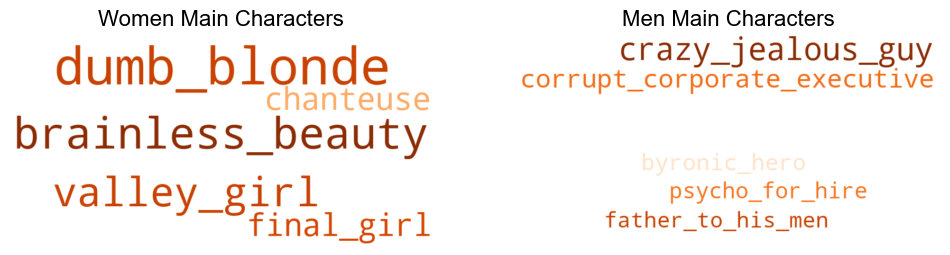

In [136]:
# Create WordClouds for women and men
women_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(women_counts)
men_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(men_counts)

# Plotting the WordClouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(women_wordcloud, interpolation='bilinear')
plt.title('Women Main Characters', color='black', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(men_wordcloud, interpolation='bilinear')
plt.title('Men Main Characters', color='black', fontsize=16)
plt.axis('off')

plt.show()

As one could expect the main character tropes that the researcher could isolate are very stereotypical. Actresses are portrayed as ‘dumb’ and the focus is only on their beauty, whereas men are more characterized by their actions ( ‘corporate’ , ‘ hero’, …).

### INCLUDE THE CLUSTERS ANALYSIS

## PART 3: Analysis of the reception of movies by the public <a id="part2.3"></a>

### Is there a difference in revenue and popularity between female-dominated and male-dominated films?

We want to analyse whether the success of a movie is correlated with the proportion of women in a movie. To do this we will take the Box Office Revenue as a measure of success, as well as the IMDb ratings given around the world to each movie.

### Looking at the ratings

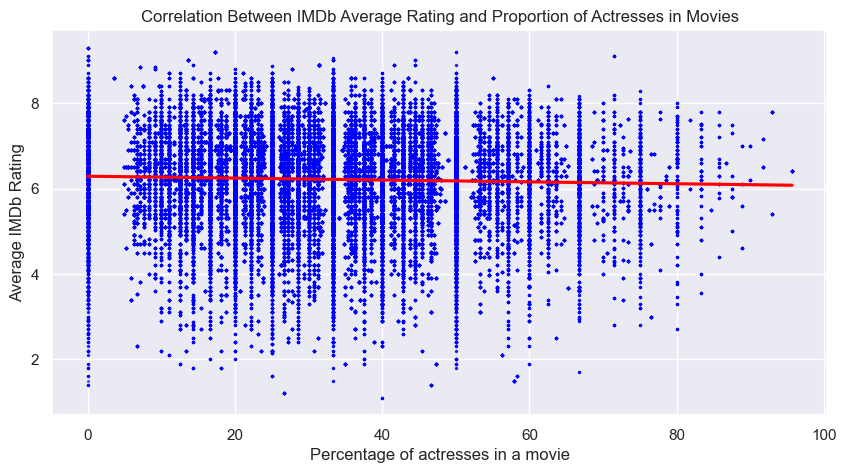

In [137]:
# We're interested only in movies for which we have information on gender distribution, so we perform a right join
ratings_gender = pd.merge(ratings, df_gender_proportion_by_movie_geo, on='WikiMovieID', how='right')

# Sort the values according to Percentage of Female 
ratings_gender.sort_values(by='PercentageofFemale', inplace=True)

plt.figure(figsize=(10,5))

sns.regplot(x=ratings_gender['PercentageofFemale'], y=ratings_gender['AverageRating'], ci=95, scatter_kws={'color': 'blue', 's': 2, 'alpha': 0.5}, line_kws={'color': 'red'})

plt.ylabel('Average IMDb Rating')
plt.xlabel('Percentage of actresses in a movie')

plt.title('Correlation Between IMDb Average Rating and Proportion of Actresses in Movies')

plt.show()

We do a linear regression to see the correlation between the percentage of women in movies and the rating given on IMDb. This shows us that there is a slight negative correlation, meaning that movies with a higher percentage of women tend to have a slightly worse rating. Here we only have a first glimpse of the situation; we need to exclude potential confounders from our analysis. 

### Looking at the Box office revenue

Aside from how a movie has been rated on IMDb, it is also interesting to look at its comercial success. This gives another insight on how the movie was globally percieved and if it impacted a lot of people or not. Therefore we are now looking at the boxoffice revenue of movies where we have the information from the original CMU data set. 

/var/folders/xy/g9qngpq914dbt048l9v974zh0000gn/T/ipykernel_12098/2691133020.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



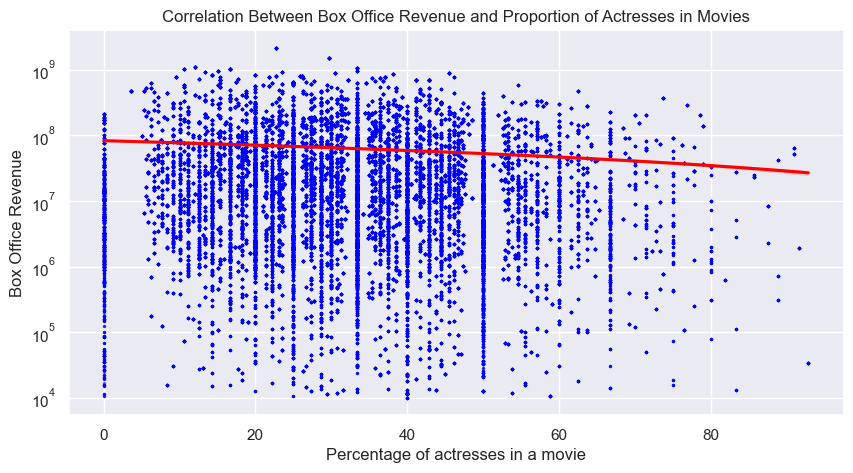

In [138]:
# Remove movies where we don't have the Box Office Revenue.
BO_ratings = ratings_gender.dropna(subset = 'BORevenue')

# Sort the values according to Percentage of Female 
BO_ratings.sort_values(by='PercentageofFemale', inplace=True)

plt.figure(figsize=(10,5))

sns.regplot(x=BO_ratings['PercentageofFemale'], y=BO_ratings['BORevenue'], ci=95, scatter_kws={'color': 'blue', 's': 2, 'alpha': 0.5}, line_kws={'color': 'red'})

plt.yscale("log")
plt.ylabel('Box Office Revenue')
plt.xlabel('Percentage of actresses in a movie')

plt.title('Correlation Between Box Office Revenue and Proportion of Actresses in Movies')

plt.show()

We do a linear regression to see the correlation between the percentage of women in movies and the Box Office Revenue. This shows us that there is a negative correlation, meaning that movies with a higher percentage of women tend to have a lower Box Office Revenue. Once again we didn't excluded potential confounders. Let's do an observational study!

### Causal Analysis: matching on release year bins, movie genre and country

We aim to conduct a more comprehensive analysis of the correlation between the percentage of female in movies and their ratings. To mitigate the influence of potential confounding factors, we employ an exact matching technique. This process involves matching movies above and below the median percentage of female based on several key criteria: movie genre, release period, and production country.

By performing exact matching in these specific areas, we ensure a closer comparison between movies with differing percentages of female representation while controlling for various influential factors. Matching based on movie genre guarantees that we're comparing films with similar thematic elements and storytelling styles, minimizing the impact of genre-specific trends on the results.
Moreover, matching based on the release period helps account for potential shifts in societal norms, industry practices, and audience expectations over time.
Additionally, exact matching based on the production country helps address potential cultural variations, regional preferences, and industry standards that might impact the portrayal of female characters in films.

In [158]:
cmu_geo_without_duplicates = cmu_geo.drop_duplicates(subset=['WikiMovieID'], keep='first')

In [159]:
# We merge with df_gender_proportion_by_movie to get the proportion of women in the movie
cmu_gender = pd.merge(cmu_geo_without_duplicates, df_gender_proportion_by_movie_geo[['WikiMovieID', 'PercentageofFemale']], on = ['WikiMovieID'], how = 'left')
cmu_gender = cmu_gender.dropna(subset=['PercentageofFemale'])

In [160]:
#Merge with the ratings dataset
ratings_without_duplicates = ratings.drop_duplicates(subset=['WikiMovieID'])
cmu_gender = pd.merge(cmu_gender, ratings_without_duplicates[['WikiMovieID', 'AverageRating']],on = ['WikiMovieID'], how= 'left' )
cmu_gender = cmu_gender.dropna(subset=['AverageRating'])
cmu_gender = cmu_gender[['WikiMovieID', 'ReleaseYear', 'MovieName', 'MovieGenre', 'Countries', 'AverageRating', 'PercentageofFemale']]

In [161]:
# Create bins for every 5 years starting from the minimum release year to the maximum release year
cmu_gender = create_bins_of_5_years(cmu_gender).copy(deep=True)

In [162]:
med_female_prop = cmu_gender['PercentageofFemale'].median()

In [163]:
cmu_gender_high_F = cmu_gender[cmu_gender['PercentageofFemale'] >= med_female_prop]
cmu_gender_low_F = cmu_gender[cmu_gender['PercentageofFemale'] < med_female_prop]

In [164]:
cmu_gender_high_F

,WikiMovieID,ReleaseYear,MovieName,MovieGenre,Countries,AverageRating,PercentageofFemale,ReleaseYearBin
0,975900,2001.0,Ghosts of Mars,{'/m/01jfsb': 'Thriller'},US,4.900000,35.294118,2000-2004
2,28463795,1988.0,Brun bitter,{'/m/0lsxr': 'Crime Fiction'},NO,5.600000,50.000000,1985-1989
4,261236,1983.0,A Woman in Flames,{'/m/07s9rl0': 'Drama'},DE,5.900000,33.333333,1980-1984
6,10408933,1938.0,Alexander's Ragtime Band,{'/m/04t36': 'Musical'},US,6.800000,50.000000,1935-1939
8,175026,1930.0,Sarah and Son,{'/m/07s9rl0': 'Drama'},US,5.400000,50.000000,1930-1934
...,...,...,...,...,...,...,...,...
44764,7761830,1990.0,Spaced Invaders,{'/m/0hqxf': 'Family Film'},US,5.300000,33.333333,1985-1989
44766,19286279,1963.0,Kalai Arasi,{'/m/02l7c8': 'Romance Film'},IN,8.200000,33.333333,1960-1964
44767,664006,1993.0,Guilty as Sin,{'/m/01jfsb': 'Thriller'},US,5.700000,37.500000,1990-1994
44769,3868432,2003.0,Into the Mirror,{'/m/03npn': 'Horror'},KR,6.400000,33.333333,2000-2004


In [165]:
#Estimated run time : 1h20

exact_match_columns = ['ReleaseYearBin', 'MovieGenre', 'Countries']

pair_high_low_F = create_pairs(exact_match_columns, cmu_gender_high_F, cmu_gender_low_F)
print('The number of matching pairs is:', len(pair_high_low_F))

Row 1 out of 14379
Row 2 out of 14379
Row 3 out of 14379
Row 4 out of 14379
Row 5 out of 14379
Row 6 out of 14379
Row 7 out of 14379
Row 8 out of 14379
Row 9 out of 14379
Row 10 out of 14379
Row 11 out of 14379
Row 12 out of 14379
Row 13 out of 14379
Row 14 out of 14379
Row 15 out of 14379
Row 16 out of 14379
Row 17 out of 14379
Row 18 out of 14379
Row 19 out of 14379
Row 20 out of 14379
Row 21 out of 14379
Row 22 out of 14379
Row 23 out of 14379
Row 24 out of 14379
Row 25 out of 14379
Row 26 out of 14379
Row 27 out of 14379
Row 28 out of 14379
Row 29 out of 14379
Row 30 out of 14379
Row 31 out of 14379
Row 32 out of 14379
Row 33 out of 14379
Row 34 out of 14379
Row 35 out of 14379
Row 36 out of 14379
Row 37 out of 14379
Row 38 out of 14379
Row 39 out of 14379
Row 40 out of 14379
Row 41 out of 14379
Row 42 out of 14379
Row 43 out of 14379
Row 44 out of 14379
Row 45 out of 14379
Row 46 out of 14379
Row 47 out of 14379
Row 48 out of 14379
Row 49 out of 14379
Row 50 out of 14379
Row 51 ou

In [167]:
#Retrieve the selected movies
balanced_proportion_female_index = [i[0] for i in list(pair_high_low_F)]+ [i[1] for i in list(pair_high_low_F)] 
balanced_proportion_female = cmu_gender.loc[balanced_proportion_female_index]

In [168]:
output_file = "balanced_proportion_female.tsv"
balanced_proportion_female.to_csv(output_file, sep='\t', index=False)

#### Linear Regression analysis

To quantify the impact of the percentage of female representation in a movie on its rating, we employ a linear regression analysis on the balanced dataset. 

Using linear regression allows us to assess the strength and direction of the relationship between the percentage of female characters in movies and their corresponding ratings. By analyzing a balanced dataset, where movies are matched based on critical criteria such as movie genre, release period, and production country, we mitigate potential confounders and focus on evaluating the specific influence of female representation on movie ratings.

Through this regression analysis, we can derive a coefficient associated with the percentage of female characters, indicating the magnitude and direction of its effect on movie ratings. A positive coefficient would suggest that a higher percentage of female characters is associated with higher ratings, while a negative coefficient would imply the opposite relationship. Additionally, the significance level of this coefficient helps determine the reliability of the relationship observed in the analysis.

In [169]:
reg_model = smf.ols(formula = ' AverageRating ~ PercentageofFemale', data = balanced_proportion_female)

results = reg_model.fit()
print(results.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:          AverageRating   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     18.69
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.54e-05
Time:                        09:57:17   Log-Likelihood:                -26660.
No. Observations:               18054   AIC:                         5.332e+04
Df Residuals:                   18052   BIC:                         5.334e+04
Df Model:                           1                                         
Covariance Type:            nonrobust  

The coefficient associated with the percentage of female is really low, but significant. This implies that, on average, as the proportion of female characters in movies increases, there tends to be a slight decrease in the movie ratings assigned by audiences or evaluators. 
The small coefficient suggests that while there's a negative association, the effect size of increasing female representation on movie ratings is minimal. This implies that other factors beyond gender representation likely have more substantial influences on how movies are rated.

### Machine Learning with and without Percentage of Female

To see if the influence of the percentage of female is significant to predict the average rating of a movie, we will train two gradient boosting regression model. Both will have the production country, the movie genre and the release year as features, but only one of them will also add the percentage of female.
If the MSE of the model including the percentage of female characters leads to a significantly lower error, it suggests that the presence of female characters is indeed a significant predictor of average movie ratings, providing insights into the importance of gender representation in influencing audience perceptions and evaluations.

In [170]:
#Keep only the name of the genre without its identifier
balanced_proportion_female['MovieGenre'] = balanced_proportion_female['MovieGenre'].apply(lambda x: list(x.values())[0])

In [171]:
# one-hot encoding country and genre
one_hot_balanced_proportion_female = pd.get_dummies(balanced_proportion_female, columns =['Countries', 'MovieGenre'], prefix = '',prefix_sep='',dtype= int)

# normalize ReleaseYear column
one_hot_balanced_proportion_female['ReleaseYearNorm'] = (one_hot_balanced_proportion_female['ReleaseYear'] - one_hot_balanced_proportion_female['ReleaseYear'].mean())/ one_hot_balanced_proportion_female['ReleaseYear'].std()

# normalize ProportionofFemale (to have percentage betweeen 0 and 1)
one_hot_balanced_proportion_female['PercentageofFemale'] = one_hot_balanced_proportion_female['PercentageofFemale']/100

In [172]:
col_Countries = balanced_proportion_female['Countries'].unique() 
col_MovieGenre = balanced_proportion_female['MovieGenre'].unique() 

In [173]:
# Model 1
X_balanced_proportion_female = numpy_helper(one_hot_balanced_proportion_female, ['ReleaseYearNorm', 'PercentageofFemale'] + list(col_Countries)+list(col_MovieGenre))
y_ratings = one_hot_balanced_proportion_female['AverageRating']

# Create the Gradient Boosting Regressor model 1
gradient_boosting_reg_1 = GradientBoostingRegressor()

# Perform the cross validation
cv_result_1 = cross_validate(gradient_boosting_reg_1, X_balanced_proportion_female , y_ratings, cv=30, scoring=('neg_mean_squared_error', 'explained_variance'))
mse_1, exp_var_1 = cv_result_1['test_neg_mean_squared_error'], cv_result_1['test_explained_variance']

print(f'The average negative mse of model 1 is: {mse_1.mean():.3f}')
print(f'The explained variance of model 1 is: {exp_var_1.mean():.3f}')

The average negative mse of model 1 is: -0.981
The explained variance of model 1 is: 0.126


In [174]:
# Model 2
# X without the column Proportion of Female
X_balanced_proportion_female_without = numpy_helper(one_hot_balanced_proportion_female, ['ReleaseYearNorm' ] + list(col_Countries) + list(col_MovieGenre))

# Create the Gradient Boosting Regressor model 2
gradient_boosting_reg_2 = GradientBoostingRegressor()

# Perform the cross validation
cv_result_2 = cross_validate(gradient_boosting_reg_2, X_balanced_proportion_female_without , y_ratings, cv=30, scoring=('neg_mean_squared_error', 'explained_variance'))
mse_2, exp_var_2 = cv_result_2['test_neg_mean_squared_error'], cv_result_2['test_explained_variance']

print(f'The average negative mse of model 2 is: {mse_2.mean():.3f}')
print(f'The explained variance of model 2 is: {exp_var_2.mean():.3f}')

The average negative mse of model 2 is: -0.983
The explained variance of model 2 is: 0.125


In [175]:
# Perform the t-test
stats.ttest_rel(mse_1, mse_2)

TtestResult(statistic=2.710906311185282, pvalue=0.011155085462363115, df=29)

### Analysis of the main character gender influence on the rating

In [ ]:
#Create a dataframe containing the main character's gender, the release year, the production country and the movie genre.
main_char_rating = pd.merge(cmu_geo, credits, left_on=['MovieName', 'ActorName'], right_on=['title', 'main_actor'], how='inner')
main_char_rating= main_char_rating.drop_duplicates(subset='WikiMovieID')

#Add the ratings of the movies.
main_char_rating= pd.merge(main_char_rating, ratings_without_duplicates[['WikiMovieID', 'AverageRating']],on = ['WikiMovieID'], how= 'inner' )
main_char_rating = main_char_rating.dropna(subset='AverageRating')

display(main_char_rating)

In [ ]:
# Create bins for every 5 years starting from the minimum release year to the maximum release year
main_char_rating = create_bins_of_5_years(main_char_rating).copy(deep=True)
display(main_char_rating)

In [ ]:
#Keep only the columns we are interested in 
main_char_rating = main_char_rating[['WikiMovieID', 'MovieName', 'Countries', 'MovieGenre', 'main_char_gender', 'AverageRating', 'ReleaseYearBin', 'ReleaseYear']].copy(deep=True)
display(main_char_rating)

In [ ]:
#Separate the dataset in two based on the gender of the main character
main_char_rating_female = main_char_rating[main_char_rating['main_char_gender'] == 'F']
main_char_rating_male = main_char_rating[main_char_rating['main_char_gender'] == 'M']

In [ ]:
#Match exactly on the release year period, the movie genre and the production country
exact_match_columns = ['ReleaseYearBin', 'MovieGenre', 'Countries']

pair_main_char_gender = create_pairs(exact_match_columns, main_char_rating_male, main_char_rating_female)
print('The number of matching pairs is:', len(pair_main_char_gender))

In [ ]:
#Retrieve the movies in the original dataset and create a new balanced dataset
balanced_main_char_index = [i[0] for i in list(pair_main_char_gender)]+ [i[1] for i in list(pair_main_char_gender)] 
balanced_main_char = main_char_rating.loc[balanced_main_char_index]

In [ ]:
#Create new columns to indicate the main character gender
balanced_main_char = pd.get_dummies(balanced_main_char, columns =['main_char_gender'], prefix = '',prefix_sep='', dtype= int)
balanced_main_char.rename(columns={'F': 'MainCharFemale', 'M': 'MainCharMale'}, inplace=True)
display(balanced_main_char)

#### Linear Regression

In [ ]:
reg_model_main_char = smf.ols(formula = 'AverageRating ~ MainCharFemale', data = balanced_main_char)

results_main_char = reg_model_main_char.fit()
print(results_main_char.summary())

#### GradientBoostingRegression

In [ ]:
#Keep only the name of the genre without its identifier
balanced_main_char['MovieGenre'] = balanced_main_char['MovieGenre'].apply(lambda x: list(x.values())[0])

In [ ]:
#One-hot encode country and genre
one_hot_balanced_main_char = pd.get_dummies(balanced_main_char, columns =['Countries', 'MovieGenre'], prefix = '',prefix_sep='',dtype= int)

#Add the ReleaseYearcolumn
one_hot_balanced_main_char = pd.merge(one_hot_balanced_main_char, cmu_geo_without_duplicates[['WikiMovieID', 'ReleaseYear']], on = 'WikiMovieID', how='left')

#Normalize ReleaseYear column
one_hot_balanced_main_char['ReleaseYearNorm'] = (one_hot_balanced_main_char['ReleaseYear'] - one_hot_balanced_main_char['ReleaseYear'].mean())/ one_hot_balanced_main_char['ReleaseYear'].std()

In [ ]:
col_Countries = balanced_main_char['Countries'].unique() 
col_MovieGenre = balanced_main_char['MovieGenre'].unique() 

In [ ]:
# Model 1
X_balanced_main_char = numpy_helper(one_hot_balanced_main_char, ['ReleaseYearNorm', 'MainCharFemale', 'MainCharMale'] + list(col_Countries)+list(col_MovieGenre))
y_ratings = one_hot_balanced_main_char['AverageRating']

# Create the Gradient Boosting Regressor model 1
gradient_boosting_reg_1 = GradientBoostingRegressor()

# Perform the cross validation
cv_result_1 = cross_validate(gradient_boosting_reg_1, X_balanced_main_char , y_ratings, cv=30, scoring=('neg_mean_squared_error', 'explained_variance'))
mse_1, exp_var_1 = cv_result_1['test_neg_mean_squared_error'], cv_result_1['test_explained_variance']

print(f'The average negative mse of model 1 is: {mse_1.mean():.3f}')
print(f'The explained variance of model 1 is: {exp_var_1.mean():.3f}')

In [ ]:
# Model 2
X_balanced_main_char_without_gender = numpy_helper(one_hot_balanced_main_char, ['ReleaseYearNorm'] + list(col_Countries)+list(col_MovieGenre))
y_ratings = one_hot_balanced_main_char['AverageRating']

# Create the Gradient Boosting Regressor model 1
gradient_boosting_reg_2 = GradientBoostingRegressor()

# Perform the cross validation
cv_result_2 = cross_validate(gradient_boosting_reg_2, X_balanced_main_char_without_gender , y_ratings, cv=30, scoring=('neg_mean_squared_error', 'explained_variance'))
mse_2, exp_var_2 = cv_result_2['test_neg_mean_squared_error'], cv_result_2['test_explained_variance']

print(f'The average negative mse of model 2 is: {mse_2.mean():.3f}')
print(f'The explained variance of model 2 is: {exp_var_2.mean():.3f}')

In [ ]:
# Perform the t-test
stats.ttest_rel(mse_1, mse_2)

### Analysis of the main character gender influence on award nomination

We need to select some categories for our analysis. Some categories are for specific genders, like 'ACTOR,' 'ACTRESS,' 'ACTOR IN A LEADING ROLE,' or 'ACTRESS IN A LEADING ROLE.' So, we can't use these to look at how the main character's gender affects award nominations.
Moreover, some categories such as 'ASSISTANT DIRECTOR,' 'ART DIRECTION (Color),' do not seem to be related to the main character, and so neither to its gender. Therefore, we selected categories from this list that we thought could be related to the main character, and dropped those that didn't have any link with it.

In [ ]:
# Print all the award categories
award_categories = set(awards['Category'])
sorted_categories = sorted(award_categories)
print('Award categories:\n',sorted_categories)

Award categories:
 ['ACTOR', 'ACTOR IN A LEADING ROLE', 'ACTOR IN A SUPPORTING ROLE', 'ACTRESS', 'ACTRESS IN A LEADING ROLE', 'ACTRESS IN A SUPPORTING ROLE', 'ANIMATED FEATURE FILM', 'ART DIRECTION', 'ART DIRECTION (Black-and-White)', 'ART DIRECTION (Color)', 'ASSISTANT DIRECTOR', 'AWARD OF COMMENDATION', 'BEST MOTION PICTURE', 'BEST PICTURE', 'CINEMATOGRAPHY', 'CINEMATOGRAPHY (Black-and-White)', 'CINEMATOGRAPHY (Color)', 'COSTUME DESIGN', 'COSTUME DESIGN (Black-and-White)', 'COSTUME DESIGN (Color)', 'DANCE DIRECTION', 'DIRECTING', 'DIRECTING (Comedy Picture)', 'DIRECTING (Dramatic Picture)', 'DOCUMENTARY', 'DOCUMENTARY (Feature)', 'DOCUMENTARY (Short Subject)', 'DOCUMENTARY FEATURE FILM', 'DOCUMENTARY SHORT FILM', 'ENGINEERING EFFECTS', 'FILM EDITING', 'FOREIGN LANGUAGE FILM', 'INTERNATIONAL FEATURE FILM', 'MAKEUP', 'MAKEUP AND HAIRSTYLING', 'MUSIC (Adaptation Score)', 'MUSIC (Music Score of a Dramatic Picture)', 'MUSIC (Music Score of a Dramatic or Comedy Picture)', 'MUSIC (Music Sco

In [ ]:
# Select the categories that are meaningful for our analysis
categories_to_select = {'ANIMATED FEATURE FILM', 'AWARD OF COMMENDATION', 'BEST MOTION PICTURE', 'BEST PICTURE', 'CINEMATOGRAPHY', 
                        'CINEMATOGRAPHY (Black-and-White)', 'CINEMATOGRAPHY (Color)', 'DOCUMENTARY', 'DOCUMENTARY (Feature)', 'DOCUMENTARY (Short Subject)', 
                        'DOCUMENTARY FEATURE FILM', 'DOCUMENTARY SHORT FILM', 'FOREIGN LANGUAGE FILM', 'INTERNATIONAL FEATURE FILM', 
                        'SHORT FILM (Animated)', 'SHORT FILM (Dramatic Live Action)', 'SHORT FILM (Live Action)',
                        'SHORT SUBJECT (Animated)', 'SHORT SUBJECT (Cartoon)', 'SHORT SUBJECT (Color)', 'SHORT SUBJECT (Comedy)', 'SHORT SUBJECT (Live Action)', 
                        'SHORT SUBJECT (Novelty)', 'SHORT SUBJECT (One-reel)', 'SHORT SUBJECT (Two-reel)', 
                        'WRITING (Screenplay Based on Material Previously Produced or Published)', 'WRITING (Screenplay Based on Material from Another Medium)', 
                        'WRITING (Screenplay Written Directly for the Screen)', 'WRITING (Screenplay Written Directly for the Screen--based on factual material or on story material not previously published or produced)',
                        'WRITING (Screenplay)', 'WRITING (Screenplay--Adapted)', 'WRITING (Screenplay--Original)', 'WRITING (Screenplay--based on material from another medium)',
                        'WRITING (Story and Screenplay)', 'WRITING (Story and Screenplay--based on factual material or material not previously published or produced)',
                        'WRITING (Story and Screenplay--based on material not previously published or produced)', 'WRITING (Story and Screenplay--written directly for the screen)', 'WRITING (Title Writing)',
                        'WRITING', 'WRITING (Adaptation)', 'WRITING (Adapted Screenplay)', 'WRITING (Motion Picture Story)', 'WRITING (Original Motion Picture Story)',
                        'WRITING (Original Screenplay)', 'WRITING (Original Story)', 'WRITING (Screenplay Adapted from Other Material)', 'OUTSTANDING MOTION PICTURE', 'OUTSTANDING PICTURE', 
                        'OUTSTANDING PRODUCTION', 'PRODUCTION DESIGN', 'UNIQUE AND ARTISTIC PICTURE'}

non_gendered_awards = awards[awards['Category'].isin(categories_to_select)]

For further analysis, we will populate the cmu dataset with data from the awards dataset. To distinguish between movies nominated for awards and those that were not, we create a new column 'Nominated.' In this column, every movie present in the awards dataset will be assigned a value of $1$, indicating nomination, while movies in the cmu dataset not found in the awards dataset will be assigned a value of $0$.

In [ ]:
# All movies from the awards dataset are nominated to the awards, so they get a value of 1
non_gendered_awards['Nominated'] = 1
non_gendered_awards

In [ ]:
# Populate the main_char_rating dataset with awards data
awards_main_char_rating = pd.merge(main_char_rating, non_gendered_awards, on=['MovieName', 'ReleaseYear'], how='left')
display(awards_main_char_rating)

,WikiMovieID,MovieName,Countries,MovieGenre,main_char_gender,AverageRating,ReleaseYearBin,ReleaseYear,CeremonyYear,Ceremony,Category,NomineeName,Winner
0,NaN,Sunrise,NaN,NaN,NaN,NaN,NaN,1927.0,1928,1,ART DIRECTION,Rochus Gliese,False
1,NaN,The Dove;,NaN,NaN,NaN,NaN,NaN,1927.0,1928,1,ART DIRECTION,William Cameron Menzies,True
2,NaN,7th Heaven,NaN,NaN,NaN,NaN,NaN,1927.0,1928,1,ART DIRECTION,Harry Oliver,False
3,NaN,The Devil Dancer;,NaN,NaN,NaN,NaN,NaN,1927.0,1928,1,CINEMATOGRAPHY,George Barnes,False
4,NaN,Sunrise,NaN,NaN,NaN,NaN,NaN,1927.0,1928,1,CINEMATOGRAPHY,Charles Rosher,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8637,NaN,Everything Everywhere All at Once,NaN,NaN,NaN,NaN,NaN,2022.0,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,True
8638,NaN,The Fabelmans,NaN,NaN,NaN,NaN,NaN,2022.0,2023,95,WRITING (Original Screenplay),Written by Steven Spielberg & Tony Kushner,False
8639,NaN,Tár,NaN,NaN,NaN,NaN,NaN,2022.0,2023,95,WRITING (Original Screenplay),Written by Todd Field,False
8640,NaN,Triangle of Sadness,NaN,NaN,NaN,NaN,NaN,2022.0,2023,95,WRITING (Original Screenplay),Written by Ruben Östlund,False


In [ ]:
# Drop rows for which we don't have information about average rating or main character gender
awards_main_char_rating = awards_main_char_rating.dropna(subset=['AverageRating'])
awards_main_char_rating = awards_main_char_rating.dropna(subset=['main_char_gender'])

# Replace the NaN values in the 'Nominated' column by 0, as movies that weren't in the awards dataset are not nominated for awards.
awards_main_char_rating['Nominated'].fillna(0, inplace=True)
awards_main_char_rating

,WikiMovieID,MovieName,Countries,MovieGenre,main_char_gender,AverageRating,ReleaseYearBin,ReleaseYear,CeremonyYear,Ceremony,Category,NomineeName,Winner,Nominated
0,975900,Ghosts of Mars,US,{'/m/01jfsb': 'Thriller'},F,4.900000,2000-2004,2001.0,NaN,NaN,NaN,NaN,NaN,0.0
1,10408933,Alexander's Ragtime Band,US,{'/m/04t36': 'Musical'},F,6.800000,1935-1939,1938.0,1939.0,11.0,OUTSTANDING PRODUCTION,20th Century-Fox,False,1.0
2,10408933,Alexander's Ragtime Band,US,{'/m/04t36': 'Musical'},F,6.800000,1935-1939,1938.0,1939.0,11.0,WRITING (Original Story),Irving Berlin,False,1.0
3,171005,Henry V,GB,{'/m/07s9rl0': 'Drama'},M,7.497131,1985-1989,1989.0,NaN,NaN,NaN,NaN,NaN,0.0
4,77856,Mary Poppins,US,{'/m/04t36': 'Musical'},F,7.800000,1960-1964,1964.0,1965.0,37.0,CINEMATOGRAPHY (Color),Edward Colman,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12391,21772949,Casbah,US,{'/m/0lsxr': 'Crime Fiction'},F,6.000000,1945-1949,1948.0,NaN,NaN,NaN,NaN,NaN,0.0
12392,25919941,The Kreutzer Sonata,US,{'/m/02l7c8': 'Romance Film'},M,5.600000,2005-2009,2008.0,NaN,NaN,NaN,NaN,NaN,0.0
12393,7761830,Spaced Invaders,US,{'/m/0hqxf': 'Family Film'},F,5.300000,1985-1989,1990.0,NaN,NaN,NaN,NaN,NaN,0.0
12394,664006,Guilty as Sin,US,{'/m/01jfsb': 'Thriller'},F,5.700000,1990-1994,1993.0,NaN,NaN,NaN,NaN,NaN,0.0


Observational study: Matching on release year (5 year bins), movie genre, country

In [ ]:
# Separate the data into treatment and control group
awards_main_char_rating_F = awards_main_char_rating[awards_main_char_rating['main_char_gender']=='F'] #Treatment
awards_main_char_rating_M = awards_main_char_rating[awards_main_char_rating['main_char_gender']=='M'] #Control

In [ ]:
#Exactly match movies with a female or male main character on the release-year period, the movie genre and the production country
exact_match_columns = ['ReleaseYearBin', 'MovieGenre', 'Countries']

pair_main_char_gender_awards = create_pairs(exact_match_columns, awards_main_char_rating_M, awards_main_char_rating_F)
print('The number of matching pairs is:', len(pair_main_char_gender_awards))

Row 1 out of 8939


Row 2 out of 8939
Row 3 out of 8939
Row 4 out of 8939
Row 5 out of 8939
Row 6 out of 8939
Row 7 out of 8939
Row 8 out of 8939
Row 9 out of 8939
Row 10 out of 8939
Row 11 out of 8939
Row 12 out of 8939
Row 13 out of 8939
Row 14 out of 8939
Row 15 out of 8939
Row 16 out of 8939
Row 17 out of 8939
Row 18 out of 8939
Row 19 out of 8939
Row 20 out of 8939
Row 21 out of 8939
Row 22 out of 8939
Row 23 out of 8939
Row 24 out of 8939
Row 25 out of 8939
Row 26 out of 8939
Row 27 out of 8939
Row 28 out of 8939
Row 29 out of 8939
Row 30 out of 8939
Row 31 out of 8939
Row 32 out of 8939
Row 33 out of 8939
Row 34 out of 8939
Row 35 out of 8939
Row 36 out of 8939
Row 37 out of 8939
Row 38 out of 8939
Row 39 out of 8939
Row 40 out of 8939
Row 41 out of 8939
Row 42 out of 8939
Row 43 out of 8939
Row 44 out of 8939
Row 45 out of 8939
Row 46 out of 8939
Row 47 out of 8939
Row 48 out of 8939
Row 49 out of 8939
Row 50 out of 8939
Row 51 out of 8939
Row 52 out of 8939
Row 53 out of 8939
Row 54 out of 8939
R

In [ ]:
balanced_main_char_awards_index = [i[0] for i in list(pair_main_char_gender_awards)]+ [i[1] for i in list(pair_main_char_gender_awards)] 
balanced_main_char_awards = awards_main_char_rating.loc[balanced_main_char_awards_index]

In [ ]:
# Save the matched dataset
pd.DataFrame(balanced_main_char_awards).to_csv("awards_main_char_balanced.tsv", sep='\t', header=None, index=False)

In [ ]:
balanced_main_char_awards = pd.get_dummies(balanced_main_char_awards, columns =['main_char_gender'], prefix = '',prefix_sep='', dtype= int)
balanced_main_char_awards.rename(columns={'F': 'MainCharFemale', 'M': 'MainCharMale'}, inplace=True)
display(balanced_main_char_awards)

,WikiMovieID,MovieName,Countries,MovieGenre,AverageRating,ReleaseYearBin,ReleaseYear,CeremonyYear,Ceremony,Category,NomineeName,Winner,Nominated,MainCharFemale,MainCharMale
325,26178713,Music for Millions,US,{'/m/04t36': 'Musical'},6.600000,1940-1944,1944.0,NaN,NaN,NaN,NaN,NaN,0.0,1,0
7892,6121312,Mighty Joe Young,US,{'/m/01jfsb': 'Thriller'},5.902525,1995-1999,1998.0,NaN,NaN,NaN,NaN,NaN,0.0,1,0
1079,897481,Just One of the Guys,US,{'/m/01z4y': 'Comedy'},6.500000,1980-1984,1985.0,NaN,NaN,NaN,NaN,NaN,0.0,1,0
6836,1614771,Freaked,US,{'/m/0219x_': 'Indie'},6.300000,1990-1994,1993.0,NaN,NaN,NaN,NaN,NaN,0.0,1,0
1995,466340,A Cinderella Story,US,{'/m/01z4y': 'Comedy'},5.900000,2000-2004,2004.0,NaN,NaN,NaN,NaN,NaN,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,17726219,Disaster Movie,US,{'/m/03btsm8': 'Action/Adventure'},1.900000,2005-2009,2008.0,NaN,NaN,NaN,NaN,NaN,0.0,0,1
2410,23691309,Song of the Saddle,US,{'/m/04t36': 'Musical'},5.900000,1935-1939,1936.0,NaN,NaN,NaN,NaN,NaN,0.0,0,1
10526,16796383,Once Upon a Time,KR,{'/m/0lsxr': 'Crime Fiction'},5.700000,2005-2009,2008.0,NaN,NaN,NaN,NaN,NaN,0.0,1,0
3388,15233369,Slumdog Millionaire,GB,{'/m/01jfsb': 'Thriller'},8.000000,2005-2009,2008.0,2009.0,81.0,BEST PICTURE,"Christian Colson, Producer",True,1.0,0,1


In [ ]:
reg_model_main_char_awards = smf.logit(formula = 'Nominated ~ MainCharFemale', data = balanced_main_char_awards)

results_main_char_awards = reg_model_main_char_awards.fit()
print(results_main_char_awards.summary())

Optimization terminated successfully.
         Current function value: 0.359163
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Nominated   No. Observations:                 6006
Model:                          Logit   Df Residuals:                     6004
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Dec 2023   Pseudo R-squ.:               0.0004343
Time:                        21:16:07   Log-Likelihood:                -2157.1
converged:                       True   LL-Null:                       -2158.1
Covariance Type:            nonrobust   LLR p-value:                    0.1709
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.0851      0.058    -35.830      0.000      -2.199      -1.971
MainCharFemale   

## PART 4: Analysis by geographical production region <a id="part2.4"></a>

### Do we have enough movies per continent ?

In [156]:
# Keep only 1 row per movie to count the number of movies per continent
cmu_countries_filtered = cmu_geo.drop_duplicates(subset=['MovieName', 'ReleaseYear', 'Continent'])
counts_per_continent = cmu_countries_filtered.groupby('Continent').size()

In [ ]:
plt.figure(figsize=(8, 4))
counts_per_continent.plot(kind='bar')

plt.xlabel('Continents')
plt.ylabel('Number of movies')
plt.title('Number of movies per continent')

plt.show()

### Proportion of women in movie around the world

In [192]:
filtered_gender_proportion_by_movie_geo = df_gender_proportion_by_movie_geo.query("Countries in ['US', 'IN'] or Continent == 'EU'")
filtered_gender_proportion_by_movie_geo.head()

,MaleCharacters,FemaleCharacters,TotalNumberofCharacters,ReleaseYear,WikiMovieID,Countries,Continent,PercentageofFemale,PercentageofMale
60997,10,3.0,13,1992.0,3217,US,NA,23.076923,76.923077
206123,18,2.0,20,1974.0,3837,US,NA,10.000000,90.000000
42012,10,5.0,15,1986.0,3947,US,NA,33.333333,66.666667
101149,10,6.0,16,1992.0,4231,US,NA,37.500000,62.500000
309625,13,2.0,15,1995.0,4560,US,NA,13.333333,86.666667


In [193]:
avg_proportion_women_geo = filtered_gender_proportion_by_movie_geo.groupby('Countries')['PercentageofFemale'].mean().reset_index()
avg_proportion_women_geo['PercentageofFemale'] = avg_proportion_women_geo['PercentageofFemale'].round(2)
avg_proportion_women_geo.head()

,Countries,PercentageofFemale
0,AL,12.22
1,AT,30.75
2,BA,21.03
3,BE,25.14
4,BG,18.66


In [194]:
min_proportion_value = avg_proportion_women_geo['PercentageofFemale'].min()
max_proportion_value = avg_proportion_women_geo['PercentageofFemale'].max()

In [181]:
# Add the proportion of women in the GeoJSON file to be able to put it in the tooltip on the map

# Load your GeoJSON file
with open('cleaned_world-administrative-boundaries.geojson', 'r') as f:
    geojson = json.load(f)

# Create a dictionary from your DataFrame for easy access
proportion_dict = avg_proportion_women_geo.set_index('Countries')['PercentageofFemale'].to_dict()

# Iterate through the GeoJSON features and add the proportion to the properties
for feature in geojson['features']:
    country_code = feature['properties']['iso_3166_1_alpha_2_codes']
    feature['properties']['PercentageofFemale'] = proportion_dict.get(country_code)

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_world-administrative-boundaries.geojson'

In [182]:
map = folium.Map(location=[0, 0], zoom_start=2)

# Add the Choropleth layer
choropleth = folium.Choropleth(
    geo_data=geojson,  
    data=filtered_gender_proportion_by_movie_geo,
    columns=['Countries', 'PercentageofFemale'],
    key_on='feature.properties.iso_3166_1_alpha_2_codes',
    fill_color='',  
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Proportion of Women in Movies (%)',
    highlight=True,
    nan_fill_color='white', 
).add_to(map)

colormap = linear.Reds_09.scale(min_proportion_value, max_proportion_value)
colormap.caption = 'Proportion of Women in Movies (%)'
colormap.add_to(map)

# Add the tooltip
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(fields=['name', 'PercentageofFemale'], aliases=['Country: ', 'Percentage of Female (%): '], labels=True)
)

map

NameError: name 'geojson' is not defined

## Matching on ReleaseYear and Genre

Te be able to make causal conclusions with the data we have, we decided to perform matching. The goal is to obtain a dataset where the biggest confounders are balanced. We decided to match on the release year of the movies (in bins of 5 years) and on the main genre of the movie, as  we think those might influence the proportion of women in the movie. We do not match on Box office revenue or IMDB score because we don't think it is an important confounder for the coutry or the female proportion. This way the main difference remaining between the movies is the region of production. 

In [159]:
# Create bins for every 5 years starting from the minimum release year to the maximum release year
df_gender_proportion_by_movie_geo = create_bins_of_5_years(df_gender_proportion_by_movie_geo).copy(deep=True)

/var/folders/ky/pdhdq4m936n0fk__0t1jt_hw0000gn/T/ipykernel_28796/4063912378.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [197]:
# We merge with df_gender_proportion_by_movie to get the proportion of women in the movie
cmu_countries_filtered = cmu_countries_filtered.merge(df_gender_proportion_by_movie_geo[['WikiMovieID', 'PercentageofFemale']], on = 'WikiMovieID', how = 'inner')
cmu_countries_filtered.dropna(subset='PercentageofFemale')
cmu_countries_filtered = cmu_countries_filtered[['WikiMovieID', 'MovieName', 'ReleaseYear', 'MovieGenre', 'Continent', 'Countries', 'ReleaseYearBin', 'PercentageofFemale']]

In [198]:
# divide dataset according to region of interest
cmu_eu = df_gender_proportion_by_movie_geo[df_gender_proportion_by_movie_geo['Continent']== 'EU']
cmu_us = df_gender_proportion_by_movie_geo[df_gender_proportion_by_movie_geo['Countries']== 'US']
cmu_in = df_gender_proportion_by_movie_geo[df_gender_proportion_by_movie_geo['Countries']== 'IN']

In [202]:
# Exact matching between the indian and european films based on the release-year period and movie genre.
exact_match_columns = ['ReleaseYearBin', 'MovieGenre']

pair_eu_in = create_pairs(exact_match_columns, cmu_eu, cmu_in)
print('The number of matching pairs is:', len(pair_eu_in))

Row 1 out of 10215
Row 2 out of 10215
Row 3 out of 10215
Row 4 out of 10215
Row 5 out of 10215
Row 6 out of 10215
Row 7 out of 10215
Row 8 out of 10215
Row 9 out of 10215
Row 10 out of 10215
Row 11 out of 10215
Row 12 out of 10215
Row 13 out of 10215
Row 14 out of 10215
Row 15 out of 10215
Row 16 out of 10215
Row 17 out of 10215
Row 18 out of 10215
Row 19 out of 10215
Row 20 out of 10215
Row 21 out of 10215
Row 22 out of 10215
Row 23 out of 10215
Row 24 out of 10215
Row 25 out of 10215
Row 26 out of 10215
Row 27 out of 10215
Row 28 out of 10215
Row 29 out of 10215
Row 30 out of 10215
Row 31 out of 10215
Row 32 out of 10215
Row 33 out of 10215
Row 34 out of 10215
Row 35 out of 10215
Row 36 out of 10215
Row 37 out of 10215
Row 38 out of 10215
Row 39 out of 10215
Row 40 out of 10215
Row 41 out of 10215
Row 42 out of 10215
Row 43 out of 10215
Row 44 out of 10215
Row 45 out of 10215
Row 46 out of 10215
Row 47 out of 10215
Row 48 out of 10215
Row 49 out of 10215
Row 50 out of 10215
Row 51 ou

In [203]:
#Retrieve the movies in the original dataset
eu_in_matched = [i[0] for i in list(pair_eu_in)]+  [i[1] for i in list(pair_eu_in)] 
df_pair_eu_in= df_gender_proportion_by_movie_geo.loc[eu_in_matched]

In [204]:
eu_from_pair_eu_in = df_pair_eu_in[df_pair_eu_in['Continent']=='EU']
in_from_pair_eu_in = df_pair_eu_in[df_pair_eu_in['Countries']=='IN']

In [205]:
#Estimated run time: 40min
#Exact matching between european movies selected from the matching with the indian movies and the american movies, based on the release year period and the movie genre
pair_eu_us = create_pairs(exact_match_columns, cmu_us, eu_from_pair_eu_in)
print('The number of matching pairs is:', len(pair_eu_us))

Row 1 out of 21895
Row 2 out of 21895
Row 3 out of 21895
Row 4 out of 21895
Row 5 out of 21895
Row 6 out of 21895
Row 7 out of 21895
Row 8 out of 21895
Row 9 out of 21895
Row 10 out of 21895
Row 11 out of 21895
Row 12 out of 21895
Row 13 out of 21895
Row 14 out of 21895
Row 15 out of 21895
Row 16 out of 21895
Row 17 out of 21895
Row 18 out of 21895
Row 19 out of 21895
Row 20 out of 21895
Row 21 out of 21895
Row 22 out of 21895
Row 23 out of 21895
Row 24 out of 21895
Row 25 out of 21895
Row 26 out of 21895
Row 27 out of 21895
Row 28 out of 21895
Row 29 out of 21895
Row 30 out of 21895
Row 31 out of 21895
Row 32 out of 21895
Row 33 out of 21895
Row 34 out of 21895
Row 35 out of 21895
Row 36 out of 21895
Row 37 out of 21895
Row 38 out of 21895
Row 39 out of 21895
Row 40 out of 21895
Row 41 out of 21895
Row 42 out of 21895
Row 43 out of 21895
Row 44 out of 21895
Row 45 out of 21895
Row 46 out of 21895
Row 47 out of 21895
Row 48 out of 21895
Row 49 out of 21895
Row 50 out of 21895
Row 51 ou

In [206]:
#Retrieve the matched movies in the original dataset and create a new balanced dataset
eu_us_matched = [i[0] for i in list(pair_eu_us)]+  [i[1] for i in list(pair_eu_us)] 
df_pair_eu_us= cmu_countries_filtered.loc[eu_us_matched]
display(df_pair_eu_us)

,WikiMovieID,MovieName,ReleaseYear,MovieGenre,Continent,Countries,ReleaseYearBin,PercentageofFemale
33197,33529412,The Island,2011.0,{'/m/02l7c8': 'Romance Film'},EU,BG,2010-2014,66.666667
20220,9735679,Take Me High,1974.0,{'/m/02l7c8': 'Romance Film'},EU,GB,1970-1974,26.666667
28810,8069398,Tycoon,2003.0,{'/m/01jfsb': 'Thriller'},EU,FR,2000-2004,25.000000
8815,19848011,99 Francs,2007.0,{'/m/07s9rl0': 'Drama'},EU,FR,2005-2009,33.333333
18608,210151,"Lock, Stock and Two Smoking Barrels",1998.0,{'/m/01jfsb': 'Thriller'},EU,GB,1995-1999,0.000000
...,...,...,...,...,...,...,...,...
8111,3473828,I Love Your Work,2003.0,{'/m/07s9rl0': 'Drama'},NA,US,2000-2004,52.941176
16894,9469896,Premium,2006.0,{'/m/07s9rl0': 'Drama'},NA,US,2005-2009,36.363636
10820,5319867,Bill: On His Own,1983.0,{'/m/07s9rl0': 'Drama'},NA,US,1980-1984,42.857143
2374,26735714,People Are Funny,1946.0,{'/m/04t36': 'Musical'},NA,US,1945-1949,22.222222


In [207]:
#Separate the european and american movies from the matching
eu_from_pair_eu_us = df_pair_eu_us[df_pair_eu_us['Continent']=='EU']
us_from_pair_eu_us = df_pair_eu_us[df_pair_eu_us['Countries']=='US']
display(eu_from_pair_eu_us)

,WikiMovieID,MovieName,ReleaseYear,MovieGenre,Continent,Countries,ReleaseYearBin,PercentageofFemale
33197,33529412,The Island,2011.0,{'/m/02l7c8': 'Romance Film'},EU,BG,2010-2014,66.666667
20220,9735679,Take Me High,1974.0,{'/m/02l7c8': 'Romance Film'},EU,GB,1970-1974,26.666667
28810,8069398,Tycoon,2003.0,{'/m/01jfsb': 'Thriller'},EU,FR,2000-2004,25.000000
8815,19848011,99 Francs,2007.0,{'/m/07s9rl0': 'Drama'},EU,FR,2005-2009,33.333333
18608,210151,"Lock, Stock and Two Smoking Barrels",1998.0,{'/m/01jfsb': 'Thriller'},EU,GB,1995-1999,0.000000
...,...,...,...,...,...,...,...,...
22540,846828,The Piano Teacher,2001.0,{'/m/07s9rl0': 'Drama'},EU,FR,2000-2004,40.000000
30475,23664156,Moon Shot,2009.0,{'/m/07s9rl0': 'Drama'},EU,GB,2005-2009,12.500000
21891,3479663,La femme publique,1984.0,{'/m/07s9rl0': 'Drama'},EU,FR,1980-1984,25.000000
19757,27789284,A Date with a Dream,1948.0,{'/m/04t36': 'Musical'},EU,GB,1945-1949,40.000000


In [208]:
#Create a list of pairs of indexes with the first element being the european movie and the second element the associated indian movie.
id_pair_eu_in = []
for pair in pair_eu_in:
    if df_pair_eu_in['Countries'].loc[pair[0]] == 'IN':
        new_row = [pair[1], pair[0]]
    else :
        new_row = [pair[0], pair[1]]
    id_pair_eu_in.append(new_row)

In [209]:
#Create a list of pairs of indexes with the first element being the european movie and the second element the associated american movie.
id_pair_eu_us = []
for pair in pair_eu_us:
    if df_pair_eu_us['Countries'].loc[pair[0]] == 'US':
        new_row = [pair[1], pair[0]]
    else :
        new_row = [pair[0], pair[1]]
    id_pair_eu_us.append(new_row)

In [210]:
#Match the european, indian and american movies together to create triplets of matched movies, with the same release-year period and movie genre.
eu_selected = np.intersect1d([pair[0] for pair in id_pair_eu_us], [pair[0] for pair in id_pair_eu_in])
us_selected = [pair[1] for pair in id_pair_eu_us]

dict_id_pair_eu_in = dict(id_pair_eu_in)
in_selected = [dict_id_pair_eu_in[eu_id] for eu_id in eu_selected]

id_perfect_matched_movies = list(eu_selected) + list(in_selected) + list(us_selected)

balanced_geo = cmu_countries_filtered.loc[id_perfect_matched_movies]
balanced_geo

,WikiMovieID,MovieName,ReleaseYear,MovieGenre,Continent,Countries,ReleaseYearBin,PercentageofFemale
2,28463795,Brun bitter,1988.0,{'/m/0lsxr': 'Crime Fiction'},EU,NO,1985-1989,50.000000
3,9363483,White Of The Eye,1987.0,{'/m/01jfsb': 'Thriller'},EU,GB,1985-1989,50.000000
4,261236,A Woman in Flames,1983.0,{'/m/07s9rl0': 'Drama'},EU,DE,1980-1984,33.333333
11,171005,Henry V,1989.0,{'/m/07s9rl0': 'Drama'},EU,GB,1985-1989,15.000000
17,22087420,"Ferdinando I, re di Napoli",1959.0,{'/m/01z4y': 'Comedy'},EU,FR,1955-1959,0.000000
...,...,...,...,...,...,...,...,...
8111,3473828,I Love Your Work,2003.0,{'/m/07s9rl0': 'Drama'},NA,US,2000-2004,52.941176
16894,9469896,Premium,2006.0,{'/m/07s9rl0': 'Drama'},NA,US,2005-2009,36.363636
10820,5319867,Bill: On His Own,1983.0,{'/m/07s9rl0': 'Drama'},NA,US,1980-1984,42.857143
2374,26735714,People Are Funny,1946.0,{'/m/04t36': 'Musical'},NA,US,1945-1949,22.222222


In [357]:
mean_perc_eu = balanced_eu['PercentageofFemale'].mean()
mean_perc_us = balanced_us['PercentageofFemale'].mean()
mean_perc_in = balanced_in['PercentageofFemale'].mean()

print(f'The average percentage of actresses in european movies is {mean_perc_eu}%.')
print(f'The average percentage of actresses in american movies is {mean_perc_us}%.')
print(f'The average percentage of actresses in indian movies is {mean_perc_in}%.')

The average percentage of actresses in european movies is 31.680717506758306%.
The average percentage of actresses in american movies is 33.70394860402623%.
The average percentage of actresses in indian movies is 33.5200763836648%.


We notice that the European movies seem to have a lower mean percentage of actresses than American and Indian movies. Let's explore this more formally with an ANOVA (Analysis of Variance).

## ANOVA
We want to assess the causal impact of the geographical region of production of a movie on the proportion of female


In [ ]:
#Load the balanced_geo if already computed
if os.path.exists("balanced_geo.tsv"):
    balanced_geo = pd.read_csv("balanced_geo.tsv", sep='\t', index_col=0)

In [211]:
# Separate according to region
balanced_eu = balanced_geo[balanced_geo['Continent']== 'EU']
balanced_us = balanced_geo[balanced_geo['Countries']== 'US']
balanced_in = balanced_geo[balanced_geo['Countries']== 'IN']

In [212]:
stats.f_oneway(balanced_eu['PercentageofFemale'],balanced_us['PercentageofFemale'],balanced_in['PercentageofFemale'])

F_onewayResult(statistic=13.002140903905843, pvalue=2.2887709312005017e-06)

The p-value is smaller than 0.05, this implies that the difference in the percentage of female is significantly different in at least one of the three regions. Howerver, this does not tell us which groups are different from each other. We therefore must conduct a post hoc test, the Tukey's test allows to make pairwise comparisons between the means of each group.

## Tukey's Test

The Tukey's test is a statistical test allowing to compare the means of more than 2 groups two-by-two. 

In [240]:
tukey_df = balanced_geo[['WikiMovieID', 'PercentageofFemale', 'Countries']]

# Transform Countries colum to have US, IN or EU:
tukey_df['Countries'] = tukey_df['Countries'].apply(lambda x: 'EU' if (x != 'US' and x != 'IN') else x)

tukey_test = pairwise_tukeyhsd(endog = tukey_df['PercentageofFemale'], groups = tukey_df['Countries'], alpha = 0.05)

print(tukey_test)


/var/folders/xy/g9qngpq914dbt048l9v974zh0000gn/T/ipykernel_12098/1527583383.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    EU     IN   1.8394 0.0001  0.8108 2.8679   True
    EU     US   2.0232    0.0  0.9947 3.0518   True
    IN     US   0.1839 0.9078 -0.8447 1.2124  False
---------------------------------------------------


The results of the Tukey's test indicate that the European movies have a significantly different mean of percentage of female characters compared to American and Indian movies.
The proportion of feminine characters between American and Indian movies is not significantly different.

In [244]:
tukey_df['Countries'] = tukey_df['Countries'].apply(lambda x : str(x))

/var/folders/xy/g9qngpq914dbt048l9v974zh0000gn/T/ipykernel_12098/3625554476.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EU vs. US: Custom statistical test, P_val:1.209e-05
US vs. IN: Custom statistical test, P_val:9.078e-01
EU vs. IN: Custom statistical test, P_val:8.269e-05


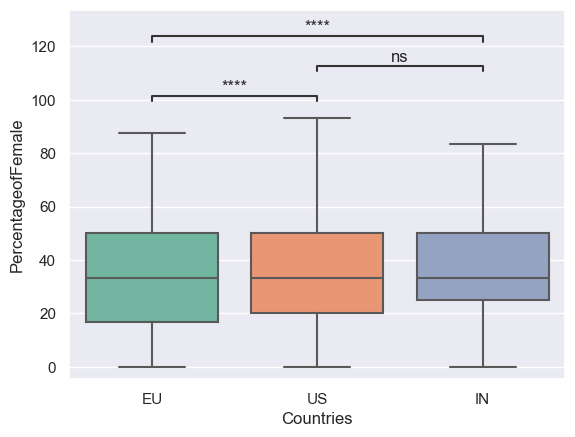

In [253]:
order= ['EU', 'US', 'IN']
ax = sns.boxplot(data = tukey_df, x = 'Countries', y='PercentageofFemale', order=order)

box_pairs = [("EU", "IN"), ("EU", "US"), ("IN", "US")]
pvalues = tukey_test.pvalues

annotator = Annotator(ax, box_pairs, data = tukey_df, x='Countries', y='PercentageofFemale', order=order )
annotator.configure(text_format='star', loc='inside')
annotator.set_pvalues_and_annotate(pvalues)
plt.show()